In [ ]:
## INSTRUCTIONS BEFORE RUNNING THE NOTEBOOK
## For the paraphrasing Model the rutime type needs to be changed to GPU. 
## Hence, it would be better to change setting in the beginning.
## To do that: go to "Runtime" -> "Change runtime type" -> select "GPU"

# About the project

Topics:

1. Training models for Sentence Similarity task using sentence-transformer library. 

2. Using pretrained paraphrasing model.

2. Through this notebook, we learned to train **bert-base**, **distilroberta-base**, **microsoft/MPNET** for downstream task like sentence similarity.

3.  **What makes our project special?** We are using a pretrained paraphrasing models to paraphrase a dataset. Then we use our fine-tuned sentence similarity models to evaluate how close the meaning of paraphrased query is to original sentence. Through this process, we determine accuracy of paraphrasing model. In a way, we are using similarity models as a metrics to test paraphrase model.

# Sentence Similarity 
Sentence similarity or semantic textual similarity is a measure of how similar two pieces of text are, or to what degree they express the same meaning. 

In this notebook, we have fine-tunned the following three models for sentence similarity task and compared the results with the base version:

1. **bert-base-uncased** with COCO caption dataset.
2. **bert-base-uncased** with STS Benchmark dataset.
3. **microsoft/mpnet-base** with STS Benchmark dataset.
4. **distilroberta-base** with STS Benchmark dataset.

||Name |
|-|:|
|**Model 1 & 2** |  [bert-base-cased](https://huggingface.co/bert-base-cased) |
|**Model 3** |  [microsoft/mpnet-base](https://huggingface.co/microsoft/mpnet-base) |
|**Model 4**  |	[distilroberta-base](https://huggingface.co/distilroberta-base)|



## Model 1 

||Model_base|model_1_trained_coco|model_1_trained_sts|
|-|-|-|:|
|**Name** |  bert-base-cased | bert-base-cased_COCO (Fine-tuned)| bert-base-cased_sts (Fine-tuned)
|****Transformer Blocks**** |	12| 	12| 12|
|**Parameters** |	 110 Million| 	110 Million| 110 Million|
|**Training Data** |	 BooksCorpus, English Wikipedia | + COCO Caption | + STS Benchmark
|**Model Card** |[Model Card](https://huggingface.co/bert-base-cased)| [Model Card](https://huggingface.co/Charul1223/bert-base-cased_coco_caption)|[Model Card](https://huggingface.co/Charul1223/bert-base-cased-on-sts)
 
 [Source Paper](https://arxiv.org/pdf/1810.04805.pdf)




## Model 2

||Model_2_Base|Model_2_trained|
|-|-|:|
|**Name** |  microsoft/mpnet-base | mpnet-base-trained-on-sts (Fine-tuned)
|**Transformer Blocks** |	12| 	12| 
|**Parameters** |	 110 Million<sup>1</sup>| 	110 Million| 
|**Training Data** |	 160GB corpus<sup>2</sup> | + STS Benchmark |
|**Model Card** |[Model Card](https://huggingface.co/microsoft/mpnet-base)| [Model Card](https://huggingface.co/Charul1223/mpnet-base-trained-on-sts)

1. **microsoft/mpnet-base** choose the configuration of BERT-base, with 12-layer Transformer, hidden size of 768, and a total of 110 million parameters.

2. For pre-training corpus, **microsoft/mpnet-base** we follow the data used in RoBERTa, which includes Wikipedia and BooksCorpus, OpenWebText, CC-News and Stories, with 160GB data size in total.

[Source Paper](https://arxiv.org/pdf/2004.09297.pdf)

## Model 3

||Model_3_Base|Model_3_trained|
|-|-|:|
|**Name** |  distilroberta-base | distilroberta-base-on-sts (Fine-tuned)|
|**Transformer Blocks** |	6| 	6| 
|**Parameters** |	 82 Million| 	82 Million| 
|**Training Data** |	 40GB corpus<sup>1</sup> | + STS Benchmark |
|**Model Card** |[Model Card](https://huggingface.co/distilroberta-base)| [Model Card](https://huggingface.co/Charul1223/distilroberta-base-on-sts)

1. DistilRoBERTa was pre-trained on [OpenWebTextCorpus](https://skylion007.github.io/OpenWebTextCorpus/), a reproduction of OpenAI's WebText dataset (it is ~4 times less training data than the teacher RoBERTa).

[Source Paper](https://arxiv.org/pdf/1910.01108.pdf)

# Data Preprocessing

## Installing dataset

In [ ]:
%%capture
!pip install datasets

In [ ]:
%%capture
!pip install sentence_transformers

In [ ]:
%%capture
from datasets import load_dataset

dataset_id = "embedding-data/coco_captions"
dataset = load_dataset(dataset_id)

In [ ]:
print(f"- The {dataset_id} dataset has {dataset['train'].num_rows} examples.")
print(f"- Each example is a {type(dataset['train'][0])} with a {type(dataset['train'][0]['set'])} as value.")
print(f"- Examples look like this: {dataset['train'][0]['set']}")

- The embedding-data/coco_captions dataset has 82783 examples.
- Each example is a <class 'dict'> with a <class 'list'> as value.
- Examples look like this: ['A clock that blends in with the wall hangs in a bathroom. ', 'A very clean and well decorated empty bathroom', 'A bathroom with a border of butterflies and blue paint on the walls above it.', 'An angled view of a beautifully decorated bathroom.', 'A blue and white bathroom with butterfly themed wall tiles.']


In [ ]:
#Convert the examples into InputExamples. It might take around 10 seconds in Google Colab.
from sentence_transformers import InputExample

train_examples = []
test_examples = []
train_data = dataset['train']['set']
n_examples = dataset['train'].num_rows

for i in range(n_examples):
  train_examples.append(InputExample(texts=[train_data[i][0], train_data[i][1], train_data[i][2]]))

  if (len(train_data[i])>5):
    test_examples.append(train_data[i][3])
    test_examples.append(train_data[i][4])
    test_examples.append(train_data[i][5])
  if (len(train_data[i])<5 and len(train_data[i])>3):
    test_examples.append(train_data[i][3])
  if (len(train_data[i])<5 and len(train_data[i])>4):
    test_examples.append(train_data[i][4])

print("Size of Train Set:",len(train_examples))
print("Size of Test Set:",len(test_examples))

Size of Train Set: 82783
Size of Test Set: 639


In [ ]:
print(test_examples[:30])


['A white van parked out side of a large white building.', 'A seagull perches on top of a van.', 'Single seagull sits on a white van with others flying in background', 'A nice clean bathroom with a glass door shower.', 'A fairly typical bathroom with a window showing the shower', 'A hotel bathroom with a sink, toilet, and towels. ', 'A car with a dog sitting in the front seat.', 'A man and woman sharing apple cider and a doughnut', 'Two people are standing in front of an open car trunk holding drinks and a doughnut. ', 'A man holding beer and a woman holding a pastry and beer.', 'A man standing in front of a white toilet in a restroom.', 'A man is urinating in an unfinished restroom.', 'Guy in hoodie peeing in a bathroom toilet', 'A boy with blue hair brushing his teeth.', 'A man and woman standing together on a stage.', 'two people standing on a stage wearing costumes', 'An asian man and woman are standing on a stage.', 'A woman smiles while looking at her cell phone.', 'A woman holdi

In [ ]:
print(f"We have a {type(train_examples)} of length {len(train_examples)} containing {type(train_examples[0])}'s.")

We have a <class 'list'> of length 82783 containing <class 'sentence_transformers.readers.InputExample.InputExample'>'s.


## Training the models

1.   [model_1_trained_coco](https://huggingface.co/Charul1223/bert-base-cased_coco_caption) is **bert-base-cased** trained on coco_caption dataset (unlabelled). It is trained using **training_script.ipynb** file available in shared drive.


2.   [Model_1_trained_sts](https://huggingface.co/Charul1223/bert-base-cased-on-sts) is **bert-base-cased** trained on STS benchmark dataset using supervised learning (labelled). It is trained on local system using **training_script.py** file available in shared drive.


3.   [Model_2_trained](https://huggingface.co/Charul1223/mpnet-base-trained-on-sts) is **microsoft/mpnet-base** trained on STS benchmark dataset using supervised learning. It is also trained on local system using **training_script.py** file available in shared drive.
Training logs named **Training_logs_mpnet_10epochs.txt** are also available in shared drive.

4.   [Model_3_trained](https://huggingface.co/Charul1223/distilroberta-base-on-sts) is **distilroberta-base** trained on STS benchmark dataset using supervised learning. It is also trained on local system using **training_script.py** file available in shared drive.Training logs named **Training_logs_distilroberta_10epochs.txt** are also available in shared drive.



## Paraphrasing Test data

Paraphrase models are models that take sentences as input query and then reword/paraphrase the sentence so it will still have a similar meaning but it does not have the same sentence structure as input query.

The paraphrase model that was used is the Hugging Face **Pegasus_paraphrase** model. The pegasus_paraphrase model was based on the Hugging Face Pegasus mode. The number of encoder layers in this model is 16 layers. Since it is the fine-tuned Pegasus model, from the Pegasus model it is trained on C4 and HugeNews with 1.5M data.

In [ ]:
%%capture
!pip install sentence-splitter

In [ ]:
%%capture
!pip install sentencepiece

In [ ]:
## Reference link -- https://huggingface.co/tuner007/pegasus_paraphrase
##For the paraphrasing Model the rutime type needs to be changed to GPU
## in order to do that go to Runtime -> Change runtime type -> select GPU
%%capture
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

paraphrase_model_name = 'tuner007/pegasus_paraphrase'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
paraphrase_tokenizer = PegasusTokenizer.from_pretrained(paraphrase_model_name)
paraphrasing_model = PegasusForConditionalGeneration.from_pretrained(paraphrase_model_name).to(torch_device)

def get_response(input_text,num_return_sequences):
  batch = paraphrase_tokenizer.prepare_seq2seq_batch([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(torch_device)
  translated = paraphrasing_model.generate(**batch,max_length=60,num_beams=10, num_return_sequences=num_return_sequences, temperature=1.5)
  tgt_text = paraphrase_tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text

In [ ]:
# Do a for loop to iterate through the list of sentences and paraphrase each sentence in the iteration
paraphrased_test_examples = []

for i in test_examples[:30]:
  paraphrased = get_response(i,1)
  paraphrased_test_examples.append(paraphrased[0])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3732: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


In [ ]:
paraphrased_test_examples
     

['A white van is parked on the side of a building.',
 'A seagull is on top of a van.',
 'A seagull sits on a white van.',
 'The bathroom has a glass door shower.',
 'A window shows the shower in a typical bathroom.',
 'There is a bathroom in a hotel.',
 'A dog is sitting in a car.',
 'A man and woman are sharing food.',
 'Two people are standing in front of a car trunk holding drinks and doughnuts.',
 'A man and a woman are holding something.',
 'A man is standing in front of a toilet.',
 'The unfinished restroom has a man urinating in it.',
 'A guy is peeing in a bathroom.',
 'A boy is brushing his teeth.',
 'A man and woman are standing together.',
 'Two people are standing on a stage.',
 'Two people are standing on a stage.',
 'A woman is looking at her phone.',
 'A woman has a cell phone in her hand.',
 'A woman is holding a phone.',
 'A woman is taking a picture.',
 'There is a stove in the kitchen.',
 'A kitchen with pots and pans.',
 'An old stove has cooking materials on it.',


## Test data from GPT
**Query to GPT** - *Give sample testing set of 50 sentences for sentence similarity task?*

|Sentences | Similar Sentences | Similarity % by GPT|
|-|-|:|
|The cat is sleeping on the couch. | The feline is napping on the sofa.|0.9|
|I am going to the store.| I need to run some errands.| 0.7|
|The concert was amazing.|The music was fantastic. | 0.95|
|He has a pet dog.|  She owns a canine companion.| 0.8|
|The sun is shining brightly today.| It is a sunny day outside. |0.85|
|The cake tastes delicious.| The dessert is very yummy.| 0.9|
|The movie was boring and predictable.| The film was uninteresting and formulaic.|0.85 |
|The company is growing rapidly.|The business is expanding at a fast pace.| 0.95|
|She is a talented singer.|Her singing skills are impressive.| 0.9|
|The book is very long.| The novel is quite lengthy.| 0.8|
|The boy is playing with his toys. |The child is having fun with his playthings. |0.9|
|I love eating pizza.|Pizza is my favorite food.|0.95|
|The computer is running slowly.|The machine is operating sluggishly. |0.8|
|The flowers in the garden are beautiful.|The blossoms outside are stunning.|0.9|
|He is a successful businessman.|He has achieved great success in his career.|0.95|
|The weather is very cold today.| It's freezing outside right now.| 0.85|
| The car is parked in the garage.|The vehicle is stored in the carport. | 0.8|
|The concert was canceled due to rain.|The event was called off because of the bad weather. |0.9 |
|She is wearing a blue dress.|Her attire consists of a dress that is blue in color.|0.8 |
|The movie was action-packed and thrilling.|The film was filled with excitement and adventure. |0.95 |
|The restaurant serves delicious food.|The eatery offers tasty cuisine.| 0.9
|The building is very tall.| The structure is quite high.|0.8
|The dog is barking loudly.|The canine is making a lot of noise.| 0.85
|The novel is set in the 19th century.| The book takes place during the 1800s.| 0.9
| She is an excellent athlete.|Her skills as a sportsperson are outstanding.|0.9
|The laptop is very lightweight.|The computer is quite portable.| 0.85
|The beach is crowded with tourists.|The seashore is packed with visitors.| 0.9
|The cake is too sweet.| The dessert is overly sugary.|0.8
| The boy is riding his bike.|The child is cycling on his bicycle.| 0.9
|The painting is very beautiful.| The artwork is quite lovely.| 0.9
| The plane is flying through the clouds.|The aircraft is soaring above the clouds.| 0.9
|The river is flowing quickly.|The waterway is moving rapidly.| 0.9
| The boy is playing with his ball.| The child is having fun with his sphere.| 0.85
| The building is made of brick.| The structure is constructed with bricks.| 0.95
| The room is very bright.| The space is quite well-lit.|0.8
| The lake is very calm.| The body of water is quite serene.|0.9
|The man is jogging in the park.| The male is running in the green space.| 0.85
| The city is very busy.| The urban area is quite hectic.| 0.85
| The coffee is very hot.| The beverage is quite warm.| 0.85
|The phone is ringing loudly.| The mobile device is making a lot of noise.| 0.8
| The boy is watching television.| The child is viewing the TV.| 0.9
|The sky is blue.|The heavens are azure in color.| 0.85
| The train is moving very fast.| The locomotive is traveling at high speed.| 0.9
| The shirt is red in color.| The garment is of a crimson hue.| 0.8
| The movie has a happy ending.| The film concludes with a joyful outcome.| 0.9
|The cat is sleeping peacefully.| The feline is resting quietly.| 0.9
| The book is very thick.|The tome is quite bulky.| 0.8
|The city is very noisy.| The urban area is quite loud.| 0.85
|The child is crying loudly.|The kid is making a lot of noise while weeping.|0.8
| The man is walking his dog.|The male is taking his canine for a walk.| 0.9
|The cake is very moist.|The dessert is quite wet.|0.85

In [ ]:
GPT_set1 = ['The cat is sleeping on the couch.', 'I am going to the store.', 'The concert was amazing.', 'He has a pet dog.', 'The sun is shining brightly today.', 'The cake tastes delicious.', 'The movie was boring and predictable.', 'The company is growing rapidly.', 'She is a talented singer.', 'The book is very long.', 'The boy is playing with his toys.', 'I love eating pizza.', 'The computer is running slowly.', 'The flowers in the garden are beautiful.', 'He is a successful businessman.', 'The weather is very cold today.', 'The car is parked in the garage.', 'The concert was canceled due to rain.', 'She is wearing a blue dress.', 'The movie was action-packed and thrilling.','The restaurant serves delicious food.','The building is very tall.','The dog is barking loudly.','The novel is set in the 19th century.','She is an excellent athlete.','The laptop is very lightweight.','The beach is crowded with tourists.','The cake is too sweet.','The boy is riding his bike.','The painting is very beautiful.','The plane is flying through the clouds.','The river is flowing quickly.','The boy is playing with his ball.','The building is made of brick.','The room is very bright.','The lake is very calm.','The man is jogging in the park.','The city is very busy.','The coffee is very hot.','The phone is ringing loudly.','The boy is watching television.','The sky is blue.','The train is moving very fast.','The shirt is red in color.', 'The movie has a happy ending.','The cat is sleeping peacefully.','The book is very thick.','The city is very noisy.','The child is crying loudly.','The man is walking his dog.']

GPT_set2 = ['The feline is napping on the sofa.', 'I need to run some errands.', 'The music was fantastic.', 'She owns a canine companion.', 'It is a sunny day outside.', 'The dessert is very yummy.', 'The film was uninteresting and formulaic.', 'The business is expanding at a fast pace.', 'Her singing skills are impressive.', 'The novel is quite lengthy.', 'The child is having fun with his playthings.', 'Pizza is my favorite food.', 'The machine is operating sluggishly.', 'The blossoms outside are stunning.', 'He has achieved great success in his career.', 'Its freezing outside right now.', 'The vehicle is stored in the carport.', 'The event was called off because of the bad weather.', 'Her attire consists of a dress that is blue in color.', 'The film was filled with excitement and adventure.','The eatery offers tasty cuisine.','The structure is quite high.','The canine is making a lot of noise.','The book takes place during the 1800s.','Her skills as a sportsperson are outstanding.','The computer is quite portable.','The seashore is packed with visitors.','The dessert is overly sugary.','The child is cycling on his bicycle.','The artwork is quite lovely.','The aircraft is soaring above the clouds.','The waterway is moving rapidly.','The child is having fun with his sphere.','The structure is constructed with bricks.','The space is quite well-lit.','The body of water is quite serene.','The male is running in the green space.','The urban area is quite hectic.',' The beverage is quite warm.','The mobile device is making a lot of noise.','The child is viewing the TV.','The heavens are azure in color.','The locomotive is traveling at high speed.','The garment is of a crimson hue.','The film concludes with a joyful outcome.','The feline is resting quietly.','The tome is quite bulky.','The urban area is quite loud.','The kid is making a lot of noise while weeping.','The male is taking his canine for a walk.']

# Training Graphs

## Cosine-Similarity

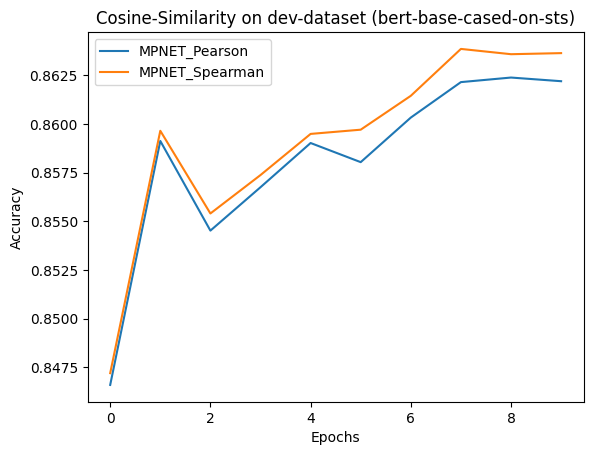

In [ ]:
# Cosine-Similarity on dev-dataset
#Charul1223/bert-base-cased-on-sts
import matplotlib.pyplot as plt

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MPNET_Pearson = [0.846602266,0.85913467,0.854529045,0.856758387,0.859029443,0.858045994,0.860335719,0.862157741,0.862392254,0.862204386
]
MPNET_Spearman = [0.847206686,0.859657478,0.855409523,0.857383497,0.859496865,0.859713693,0.861454408,0.863862703,0.8635914,0.863646781
]

plt.plot(x, MPNET_Pearson, label="MPNET_Pearson")
plt.plot(x, MPNET_Spearman, label="MPNET_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Cosine-Similarity on dev-dataset (bert-base-cased-on-sts)")
plt.legend()
plt.show()

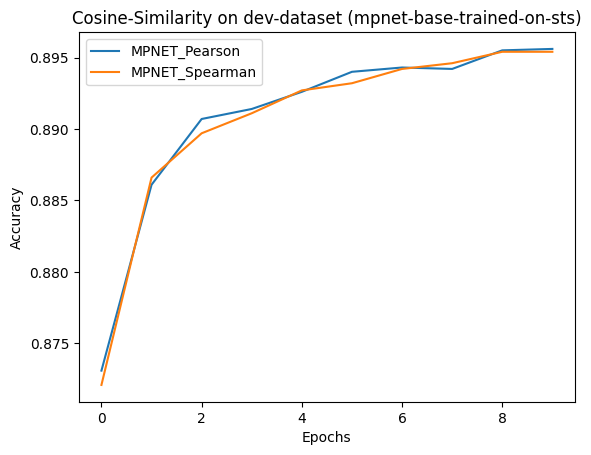

In [ ]:
#Charul1223/mpnet-base-trained-on-sts
import matplotlib.pyplot as plt
# Cosine-Similarity on dev-dataset
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MPNET_Pearson = [0.8731,0.8861,0.8907,0.8914,0.8926,0.8940,0.8943,0.8942,0.8955,0.8956]
MPNET_Spearman = [0.8721,0.8866,0.8897,0.8911,0.8927,0.8932,0.8942,0.8946,0.8954,0.8954]

plt.plot(x, MPNET_Pearson, label="MPNET_Pearson")
plt.plot(x, MPNET_Spearman, label="MPNET_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Cosine-Similarity on dev-dataset (mpnet-base-trained-on-sts)")
plt.legend()
plt.show()

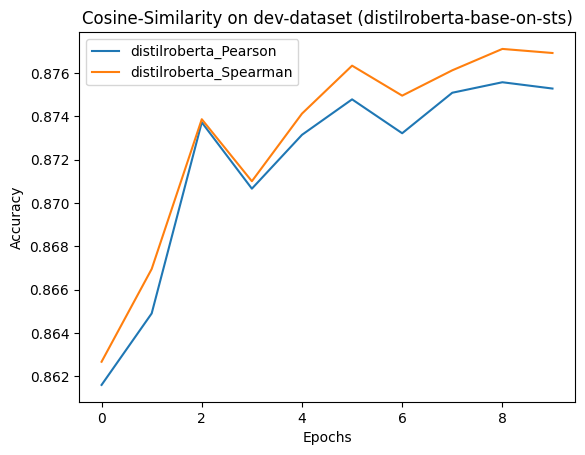

In [ ]:
# Charul1223/distilroberta-base-on-sts
# Cosine-Similarity on dev-dataset
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
distilroberta_Pearson = [0.861591489,0.86489413,0.873723601,0.870659006,0.873146253,0.874785613,0.873219801,0.875091091,0.875576081,0.875284743
]
distilroberta_Spearman = [0.862662008,0.866947333,0.873867644,0.871003048,0.874126324,0.876342537,0.874957033,0.876127683,0.877115815,0.87692732
]

plt.plot(x, distilroberta_Pearson, label="distilroberta_Pearson")
plt.plot(x, distilroberta_Spearman, label="distilroberta_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Cosine-Similarity on dev-dataset (distilroberta-base-on-sts)")
plt.legend()
plt.show()

## Manhattan-Dist

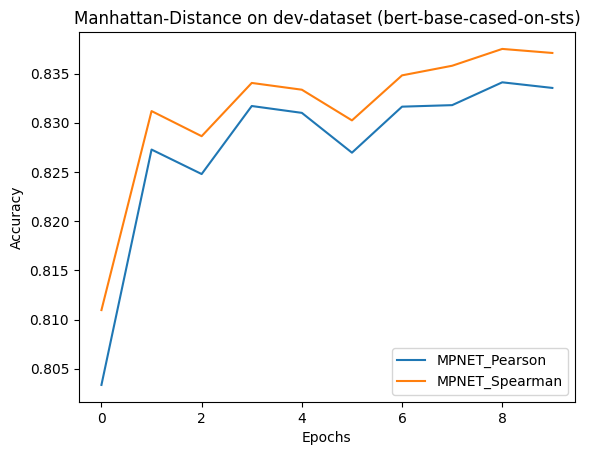

In [ ]:
# Manhattan-Distance on dev-dataset
#Charul1223/bert-base-cased-on-sts
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MPNET_Pearson = [0.803358879,0.827272877,0.824783877,0.831697164,0.831000626,0.826955365,0.831631464,0.83178582,0.834104663,0.833534292
]
MPNET_Spearman = [0.810963588,0.831182921,0.828630577,0.834041223,0.833353497,0.830236534,0.834811717,0.835788066,0.837497601,0.837086686
]

plt.plot(x, MPNET_Pearson, label="MPNET_Pearson")
plt.plot(x, MPNET_Spearman, label="MPNET_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Manhattan-Distance on dev-dataset (bert-base-cased-on-sts)")
plt.legend()
plt.show()

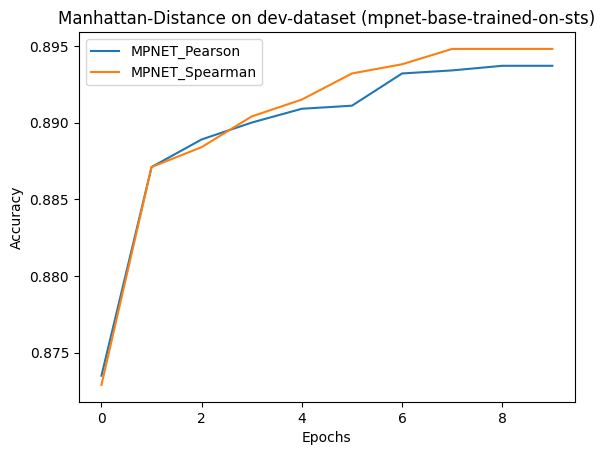

In [ ]:
#Charul1223/mpnet-base-trained-on-sts
# Manhattan-Distance on dev-dataset
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MPNET_Pearson = [0.8735,0.8871,0.8889,0.8900,0.8909,0.8911,0.8932,0.8934,0.8937,0.8937]
MPNET_Spearman = [0.8729,0.8871,0.8884,0.8904,0.8915,0.8932,0.8938,0.8948,0.8948,0.8948]

plt.plot(x, MPNET_Pearson, label="MPNET_Pearson")
plt.plot(x, MPNET_Spearman, label="MPNET_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Manhattan-Distance on dev-dataset (mpnet-base-trained-on-sts)")
plt.legend()
plt.show()

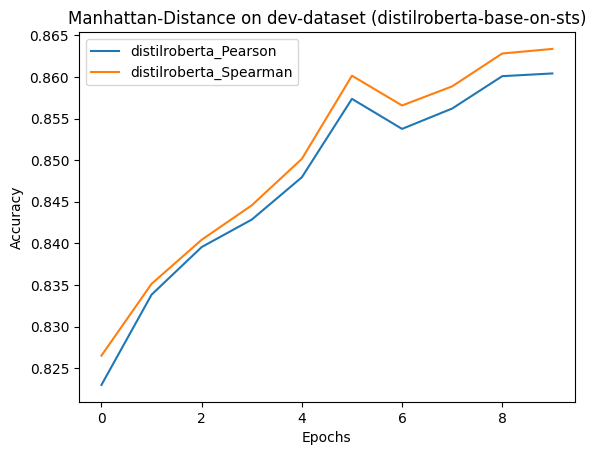

In [ ]:
# Manhattan-Distance on dev-dataset
# Charul1223/distilroberta-base-on-sts
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
distilroberta_Pearson = [0.822997206,0.833837743,0.839559694,0.842857963,0.847943234,0.857363974,0.853755291,0.856200735,0.860090373,0.860415977
]
distilroberta_Spearman = [0.826517355,0.835139583,0.840431496,0.844571761,0.850154565,0.86014651,0.85656857,0.858864011,0.862812208,0.863362521
]


plt.plot(x, distilroberta_Pearson, label="distilroberta_Pearson")
plt.plot(x, distilroberta_Spearman, label="distilroberta_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Manhattan-Distance on dev-dataset (distilroberta-base-on-sts)")
plt.legend()
plt.show()

## Euclidean-Dist

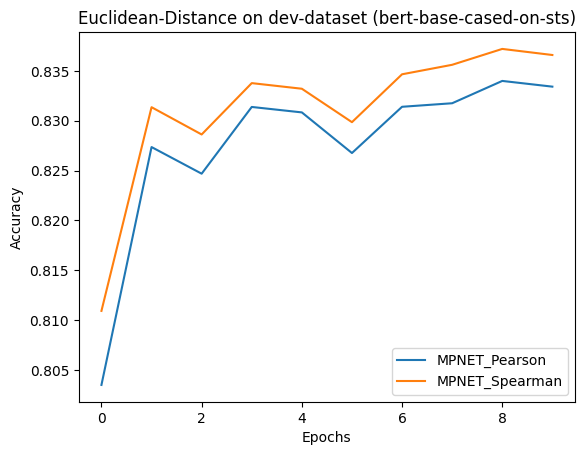

In [ ]:
# Euclidean-Distance on dev-dataset
#Charul1223/bert-base-cased-on-sts
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MPNET_Pearson = [0.803501469,0.827361546,0.824690498,0.83138411,0.830837913,0.826763083,0.831401038,0.831755981,0.833994752,0.833421265
]
MPNET_Spearman = [0.810928421,0.831359745,0.828623154,0.833774604,0.833211516,0.829857977,0.834660804,0.835612875,0.837205229,0.836595907
]
plt.plot(x, MPNET_Pearson, label="MPNET_Pearson")
plt.plot(x, MPNET_Spearman, label="MPNET_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Euclidean-Distance on dev-dataset (bert-base-cased-on-sts)")
plt.legend()
plt.show()

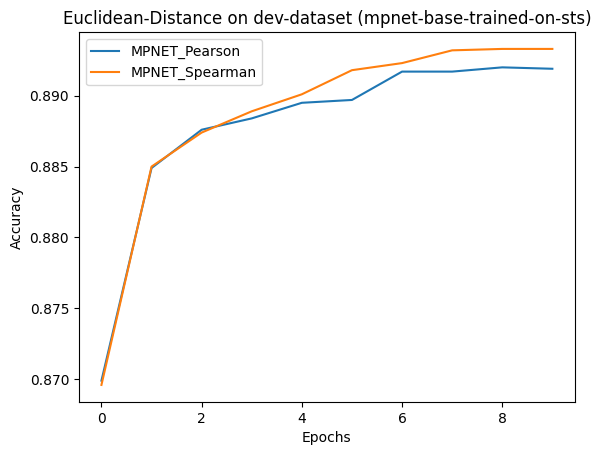

In [ ]:
# Euclidean-Distance on dev-dataset
#Charul1223/mpnet-base-trained-on-sts
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MPNET_Pearson = [0.8699,0.8849,0.8876,0.8884,0.8895,0.8897,0.8917,0.8917,0.8920,0.8919]
MPNET_Spearman = [0.8696,0.8850,0.8874,0.8889,0.8901,0.8918,0.8923,0.8932,0.8933,0.8933]
plt.plot(x, MPNET_Pearson, label="MPNET_Pearson")
plt.plot(x, MPNET_Spearman, label="MPNET_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Euclidean-Distance on dev-dataset (mpnet-base-trained-on-sts)")
plt.legend()
plt.show()

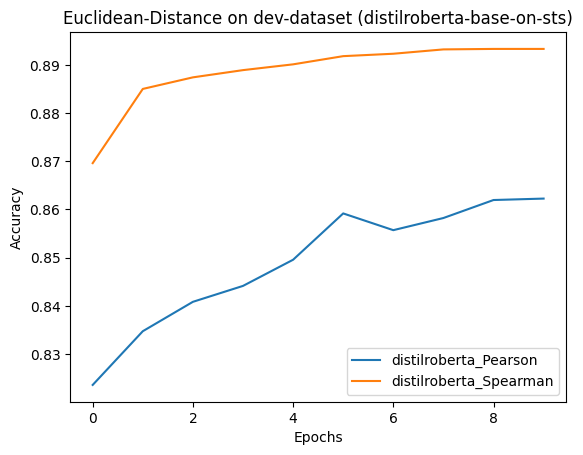

In [ ]:
# Euclidean-Distance on dev-dataset
## Charul1223/distilroberta-base-on-sts
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
distilroberta_Pearson = [0.823581825,0.834726708,0.840823957,0.844127854,0.849556874,0.859166009,0.855693387,0.858213663,0.861947932,0.862245143
]
distilroberta_Spearman = [0.827464701,0.836193573,0.841912884,0.846315239,0.852221698,0.862419914,0.858993457,0.861406388,0.865068069,0.865558914
]
plt.plot(x, distilroberta_Pearson, label="distilroberta_Pearson")
plt.plot(x, MPNET_Spearman, label="distilroberta_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Euclidean-Distance on dev-dataset (distilroberta-base-on-sts)")
plt.legend()
plt.show()

## Dot-Product

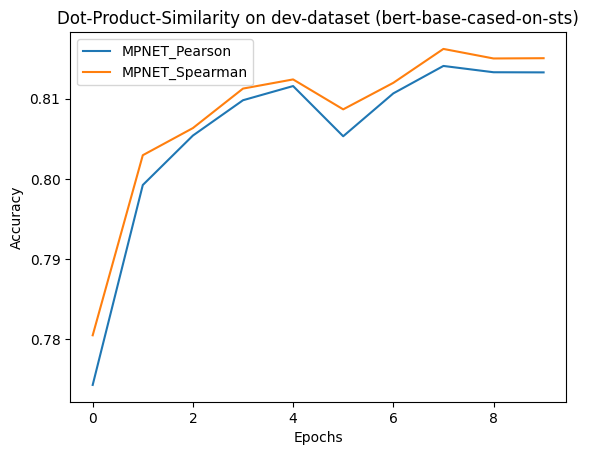

In [ ]:
# Dot-Product-Similarity on dev-dataset
# Charul1223/bert-base-cased-on-sts
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MPNET_Pearson = [0.774278961,0.799235114,0.805408891,0.809819943,0.811589133,0.805322667,0.810672673,0.814099655,0.813313382,0.813296446
]
MPNET_Spearman = [0.780474914,0.802956268,0.806343758,0.811274297,0.812416721,0.808681133,0.811991868,0.816225174,0.815033083,0.815066876
]
plt.plot(x, MPNET_Pearson, label="MPNET_Pearson")
plt.plot(x, MPNET_Spearman, label="MPNET_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Dot-Product-Similarity on dev-dataset (bert-base-cased-on-sts)")
plt.legend()
plt.show()

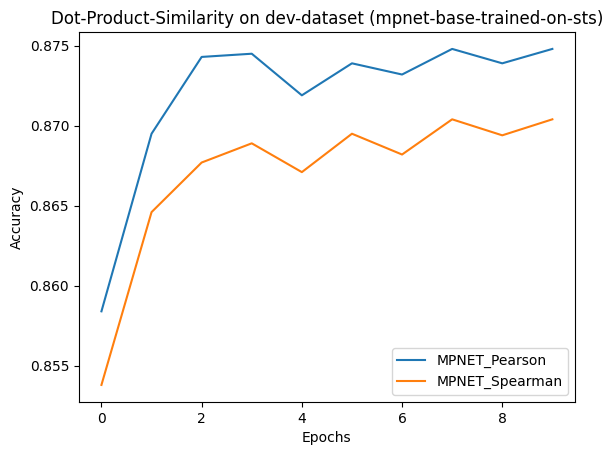

In [ ]:
# Dot-Product-Similarity on dev-dataset
# Charul1223/mpnet-base-trained-on-sts
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MPNET_Pearson = [0.8584,0.8695,0.8743,0.8745,0.8719,0.8739,0.8732,0.8748,0.8739,0.8748]
MPNET_Spearman = [0.8538,0.8646,0.8677,0.8689,0.8671,0.8695,0.8682,0.8704,0.8694,0.8704]
plt.plot(x, MPNET_Pearson, label="MPNET_Pearson")
plt.plot(x, MPNET_Spearman, label="MPNET_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Dot-Product-Similarity on dev-dataset (mpnet-base-trained-on-sts)")
plt.legend()
plt.show()

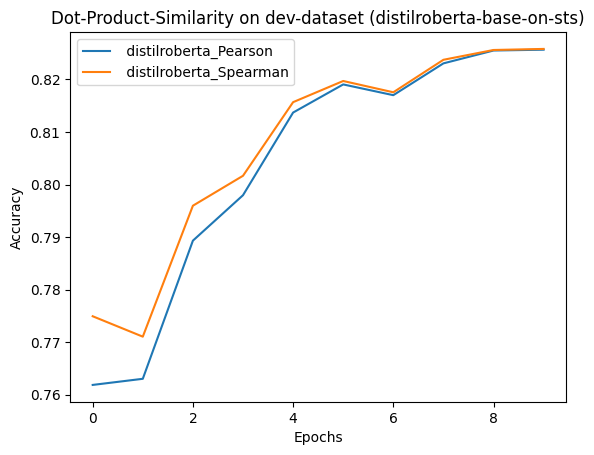

In [ ]:
# Dot-Product-Similarity on dev-dataset
# Charul1223/distilroberta-base-on-sts
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
distilroberta_Pearson = [0.761862607,0.763028208,0.789317998,0.797967434,0.81369782,0.81904957,0.817004678,0.823056844,0.825504243,0.825659341
] 
distilroberta_Spearman = [0.774929985,0.771047219,0.795969466,0.801664731,0.815675679,0.819704763,0.817554931,0.823739577,0.825604328,0.825807073
]
plt.plot(x,  distilroberta_Pearson, label=" distilroberta_Pearson")
plt.plot(x,  distilroberta_Spearman, label=" distilroberta_Spearman")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Dot-Product-Similarity on dev-dataset (distilroberta-base-on-sts)")
plt.legend()
plt.show()

# Loading all the models

In [ ]:
%%capture
#Link to my model on huggingface hub -- > [fix here]

from sentence_transformers import SentenceTransformer

model_1_base = SentenceTransformer('bert-base-cased')
model_1_trained_coco = SentenceTransformer('Charul1223/bert-base-cased_coco_caption')
model_1_trained_sts = SentenceTransformer('Charul1223/bert-base-cased-on-sts')

model_2_base = SentenceTransformer('microsoft/mpnet-base')
model_2_trained = SentenceTransformer('Charul1223/mpnet-base-trained-on-sts')

model_3_base = SentenceTransformer('distilroberta-base')
model_3_trained = SentenceTransformer('Charul1223/distilroberta-base-on-sts')

# Why bert is giving terrible results for sentence similarity? https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#43-similarity-metrics

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/microsoft_mpnet-base were not used 

# Generating Embeddings

In [ ]:
# Generate embedding for test examples from COCO dataset
model_1_base_test = model_1_base.encode(test_examples[:30])
model_1_trained_coco_test = model_1_trained_coco.encode(test_examples[:30])
model_1_trained_sts_test = model_1_trained_sts.encode(test_examples[:30])

model_2_base_test = model_2_base.encode(test_examples[:30])
model_2_trained_test = model_2_trained.encode(test_examples[:30])

model_3_base_test = model_3_base.encode(test_examples[:30])
model_3_trained_test = model_3_trained.encode(test_examples[:30])

# Generate embedding for PARAPHRASED test examples from COCO dataset
model_1_base_para = model_1_base.encode(paraphrased_test_examples)
model_1_trained_coco_para = model_1_trained_coco.encode(paraphrased_test_examples)
model_1_trained_sts_para = model_1_trained_sts.encode(paraphrased_test_examples)

model_2_base_para = model_2_base.encode(paraphrased_test_examples)
model_2_trained_para = model_2_trained.encode(paraphrased_test_examples)

model_3_base_para = model_3_base.encode(paraphrased_test_examples)
model_3_trained_para = model_3_trained.encode(paraphrased_test_examples)

In [ ]:
# Generate embedding for GPT_set1
model_1_base_gpt1 = model_1_base.encode(GPT_set1)
model_1_trained_coco_gpt1 = model_1_trained_coco.encode(GPT_set1)
model_1_trained_sts_gpt1 = model_1_trained_sts.encode(GPT_set1)

model_2_base_gpt1 = model_2_base.encode(GPT_set1)
model_2_trained_gpt1 = model_2_trained.encode(GPT_set1)

model_3_base_gpt1 = model_3_base.encode(GPT_set1)
model_3_trained_gpt1 = model_3_trained.encode(GPT_set1)

# Generate embedding for GPT_set2
model_1_base_gpt2 = model_1_base.encode(GPT_set2)
model_1_trained_coco_gpt2 = model_1_trained_coco.encode(GPT_set2)
model_1_trained_sts_gpt2 = model_1_trained_sts.encode(GPT_set2)

model_2_base_gpt2 = model_2_base.encode(GPT_set2)
model_2_trained_gpt2 = model_2_trained.encode(GPT_set2)

model_3_base_gpt2 = model_3_base.encode(GPT_set2)
model_3_trained_gpt2 = model_3_trained.encode(GPT_set2)

# Performance Evaluation Metric




## Cosine Similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.

              Similarity = (A.B) / (||A||.||B||) 
              (where A and B are vectors)

Mathematical representation:

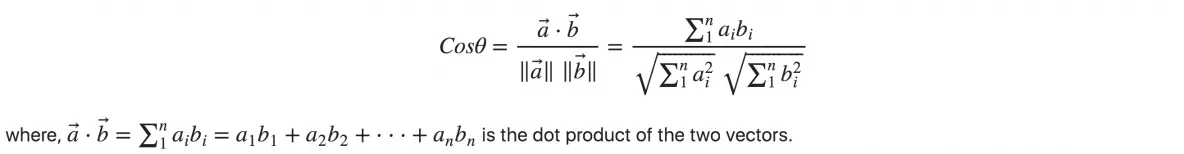

## Heatmap Visualization

In [ ]:
%%capture
!pip3 install seaborn

In [ ]:
import numpy as np
import seaborn as sns

### Original test set

#### model_1_base

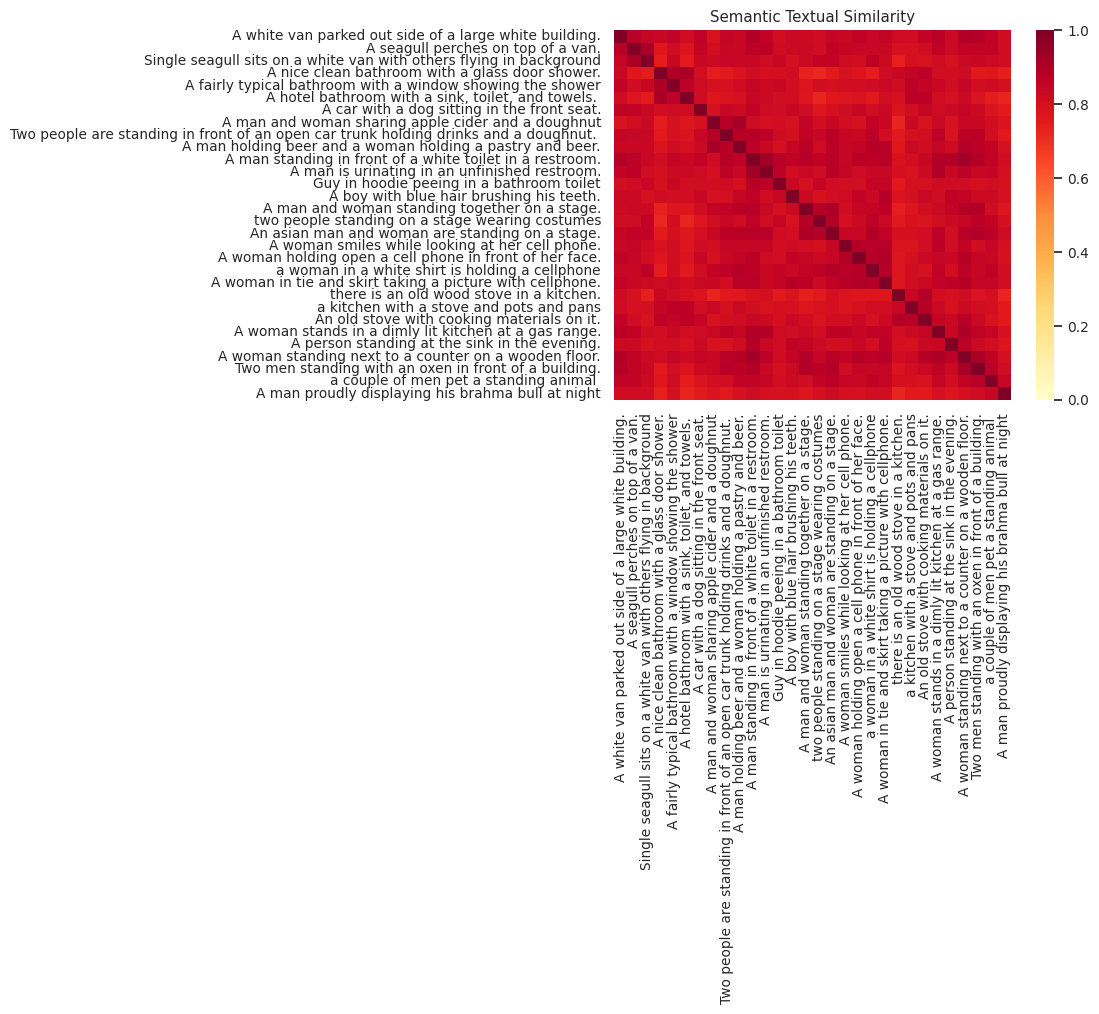

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_1_base_test, model_1_base_test)

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

# def run_and_plot(messages_):
#   message_embeddings_ = embed(messages_)
plot_similarity(test_examples[:30], test_examples[:30], model_1_base_test, model_1_base_test, 90)

#### model_1_trained_coco

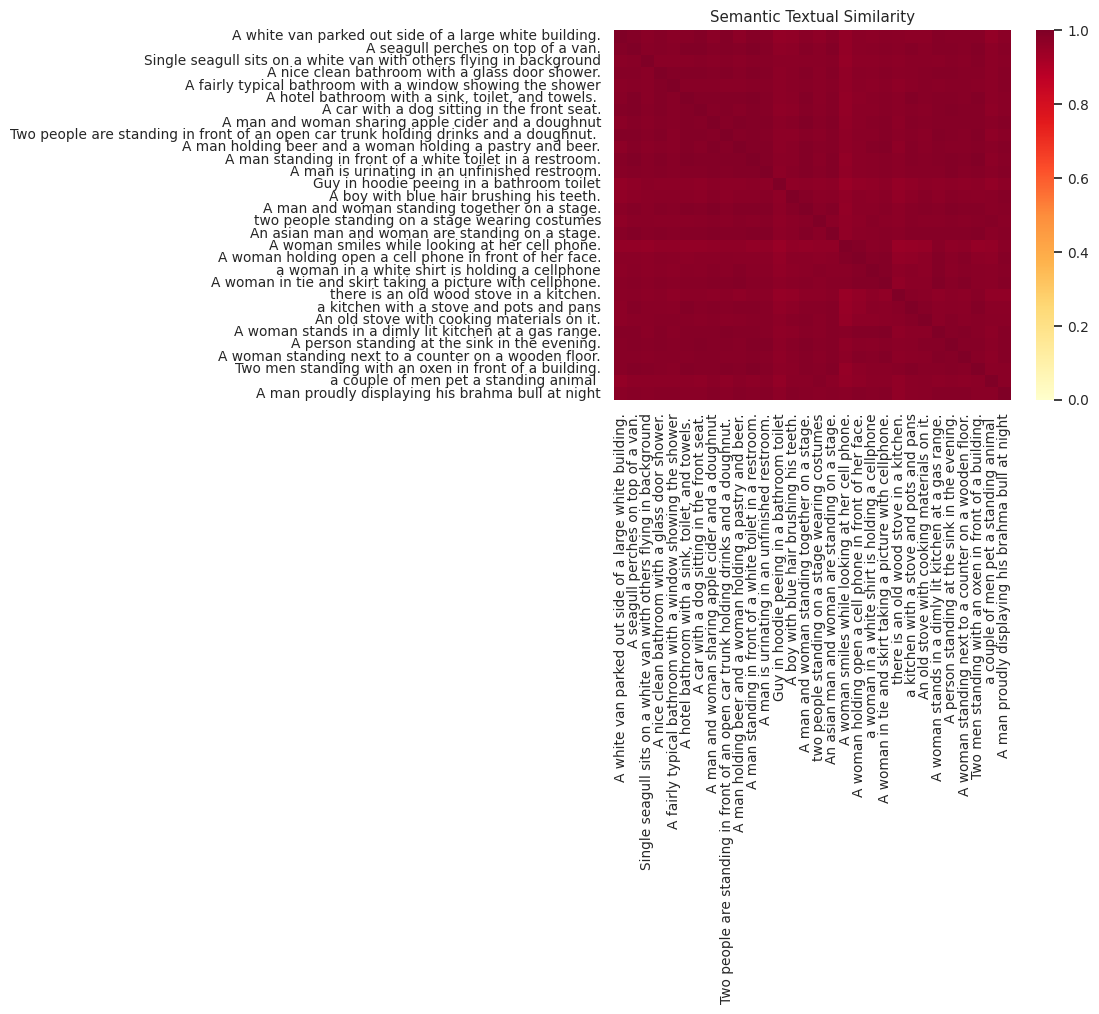

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_1_trained_coco_test, model_1_trained_coco_test)

#Output the pairs with their score
# for i in range(len(test_examples[:30])):
#     print("{} \t\t\t\t {} \t\t\t\t Score: {:.4f}".format(test_examples[i], test_examples[i], cosine_scores[i][i]))

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")



plot_similarity(test_examples[:30], test_examples[:30], model_1_trained_coco_test, model_1_trained_coco_test, 90)

#### model_1_trained_sts

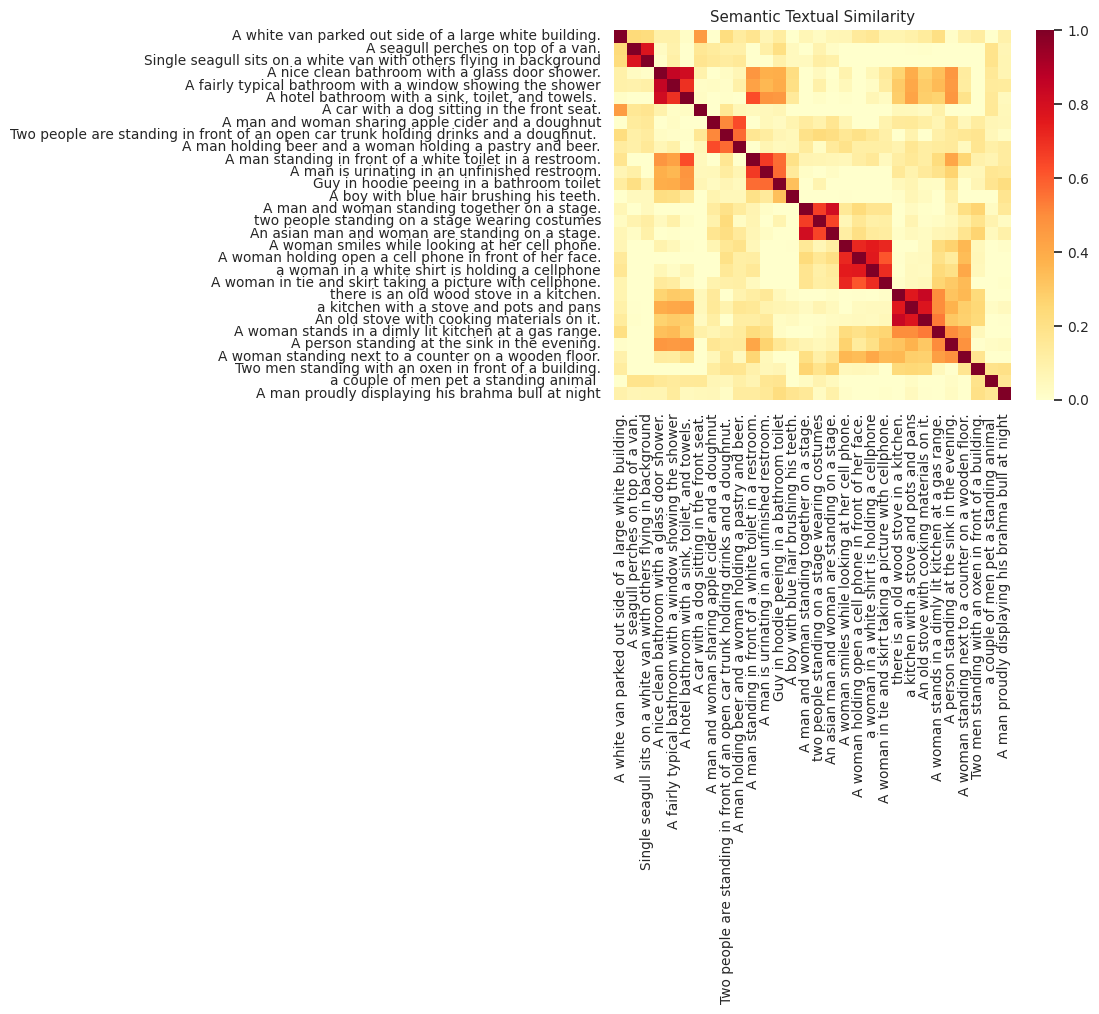

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_1_trained_sts_test, model_1_trained_sts_test)

#Output the pairs with their score
# for i in range(len(test_examples[:30])):
#     print("{} \t\t\t\t {} \t\t\t\t Score: {:.4f}".format(test_examples[i], test_examples[i], cosine_scores[i][i]))

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")



plot_similarity(test_examples[:30], test_examples[:30], model_1_trained_sts_test, model_1_trained_sts_test, 90)

#### model_2_base

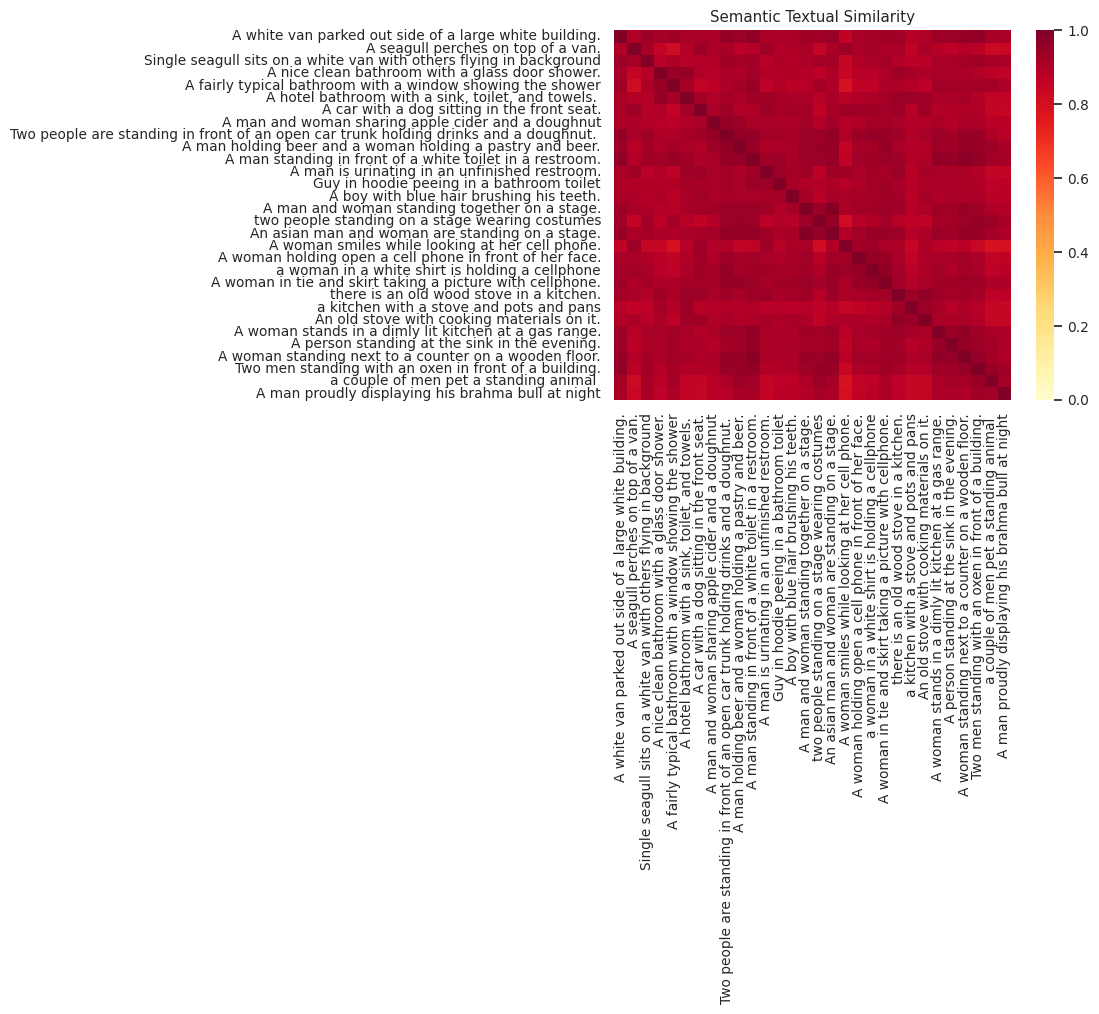

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_2_base_test, model_2_base_test)

#Output the pairs with their score
# for i in range(len(test_examples[:30])):
#     print("{} \t\t\t\t {} \t\t\t\t \t \t \t Score: {:.4f}".format(test_examples[i], test_examples[i], cosine_scores[i][i]))

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")



plot_similarity(test_examples[:30], test_examples[:30], model_2_base_test, model_2_base_test, 90)

#### model_2_trained

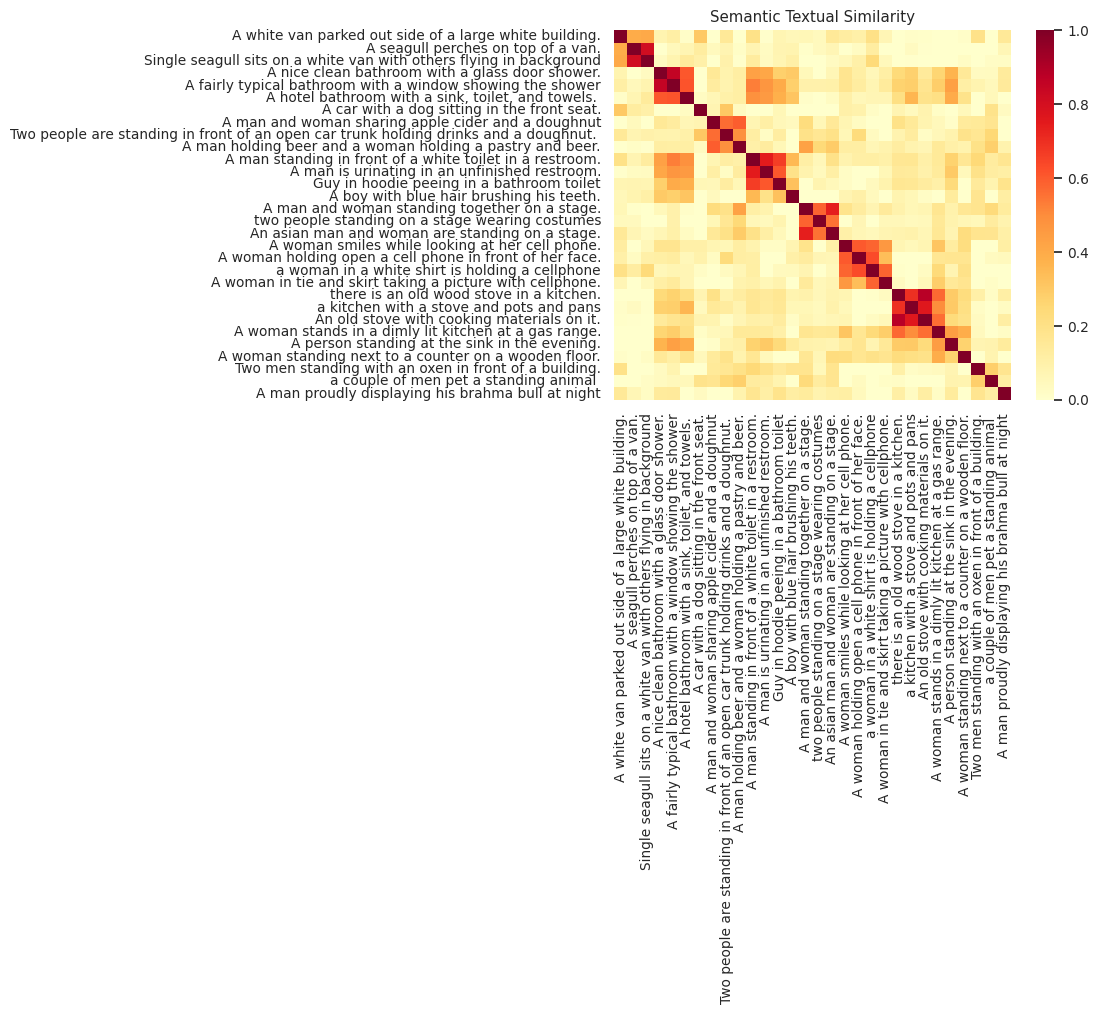

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_2_trained_test, model_2_trained_test)

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(test_examples[:30], test_examples[:30], model_2_trained_test, model_2_trained_test, 90)

#### model_3_base

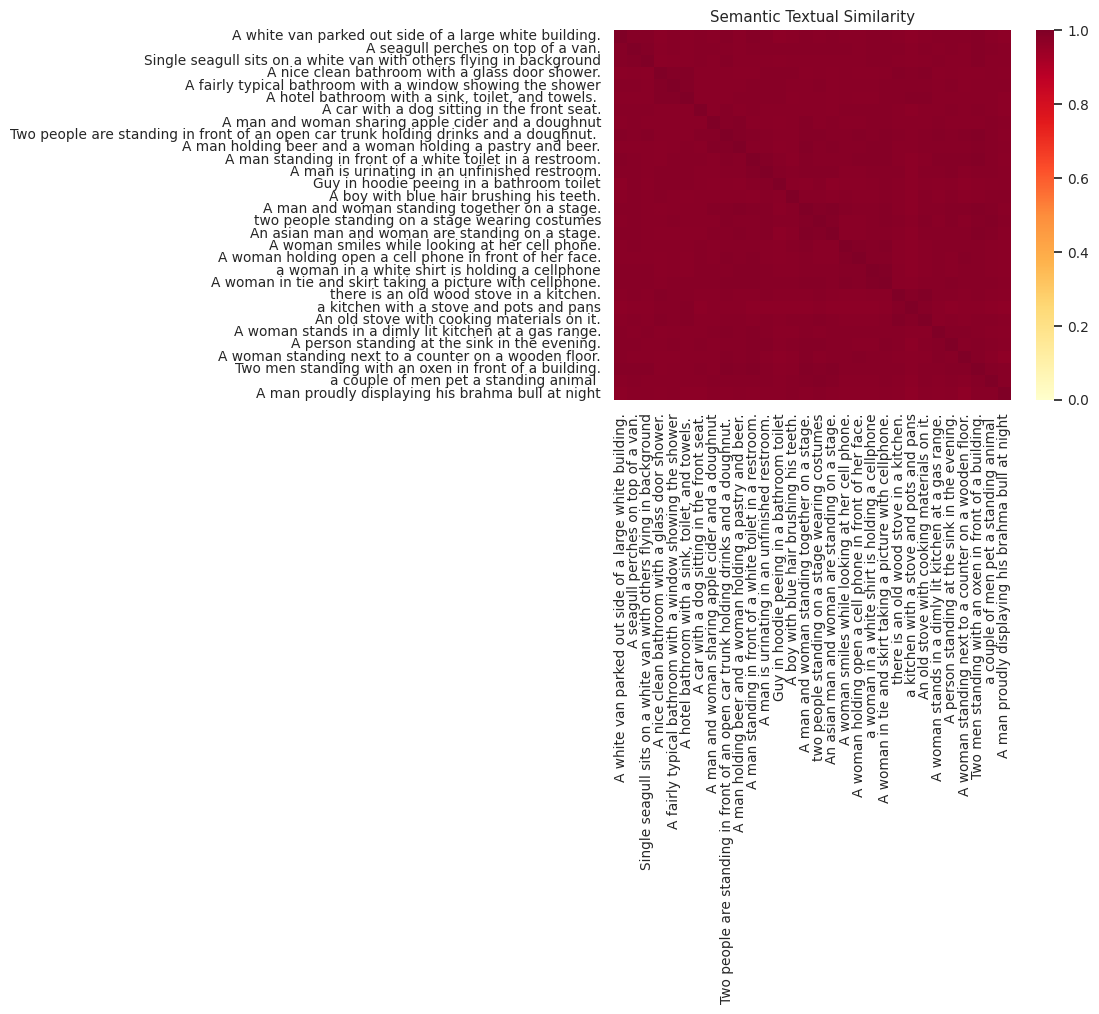

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_3_base_test, model_3_base_test)


# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(test_examples[:30], test_examples[:30], model_3_base_test, model_3_base_test, 90)

#### model_3_trained

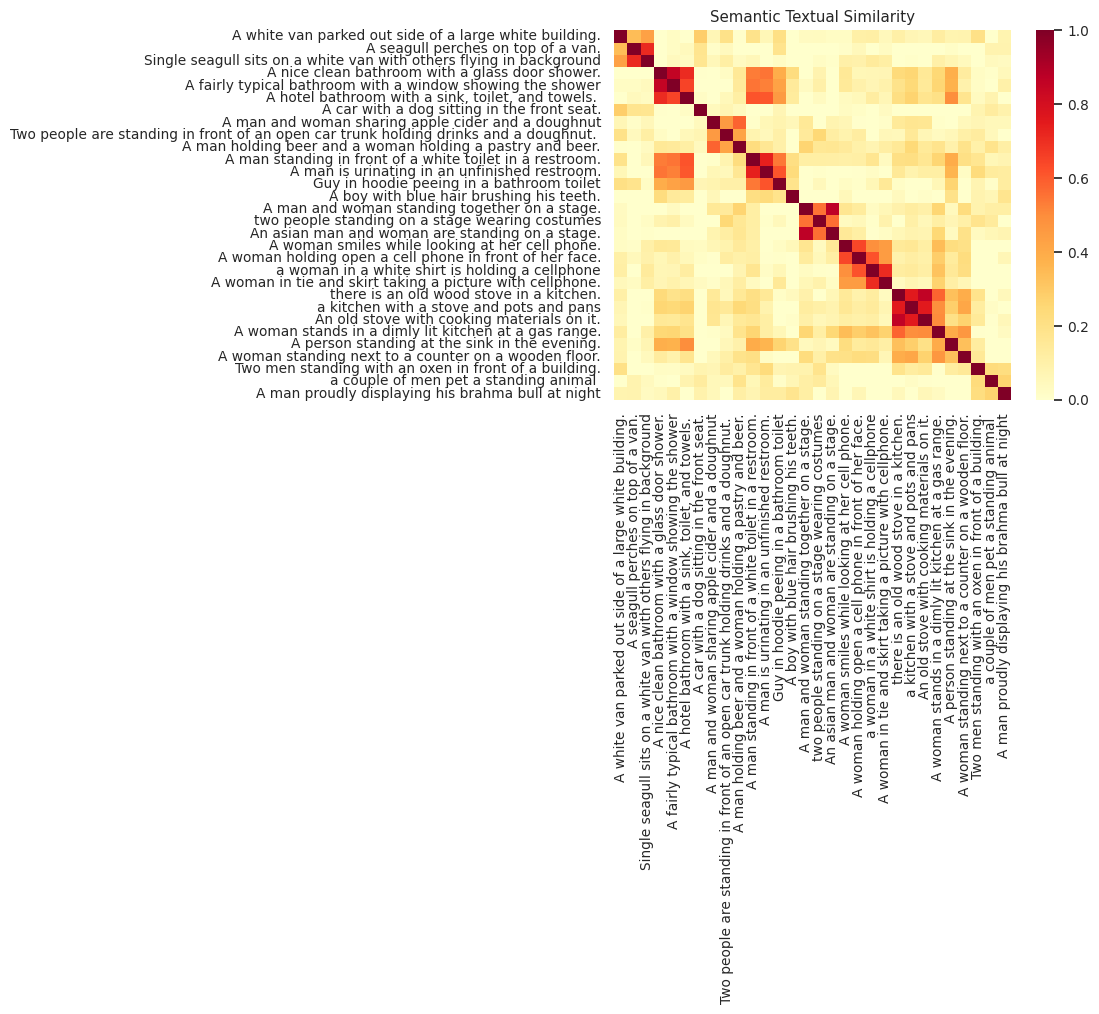

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_3_trained_test, model_3_trained_test)

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(test_examples[:30], test_examples[:30], model_3_trained_test, model_3_trained_test, 90)

### Original vs Paraphrased

#### model_1_base

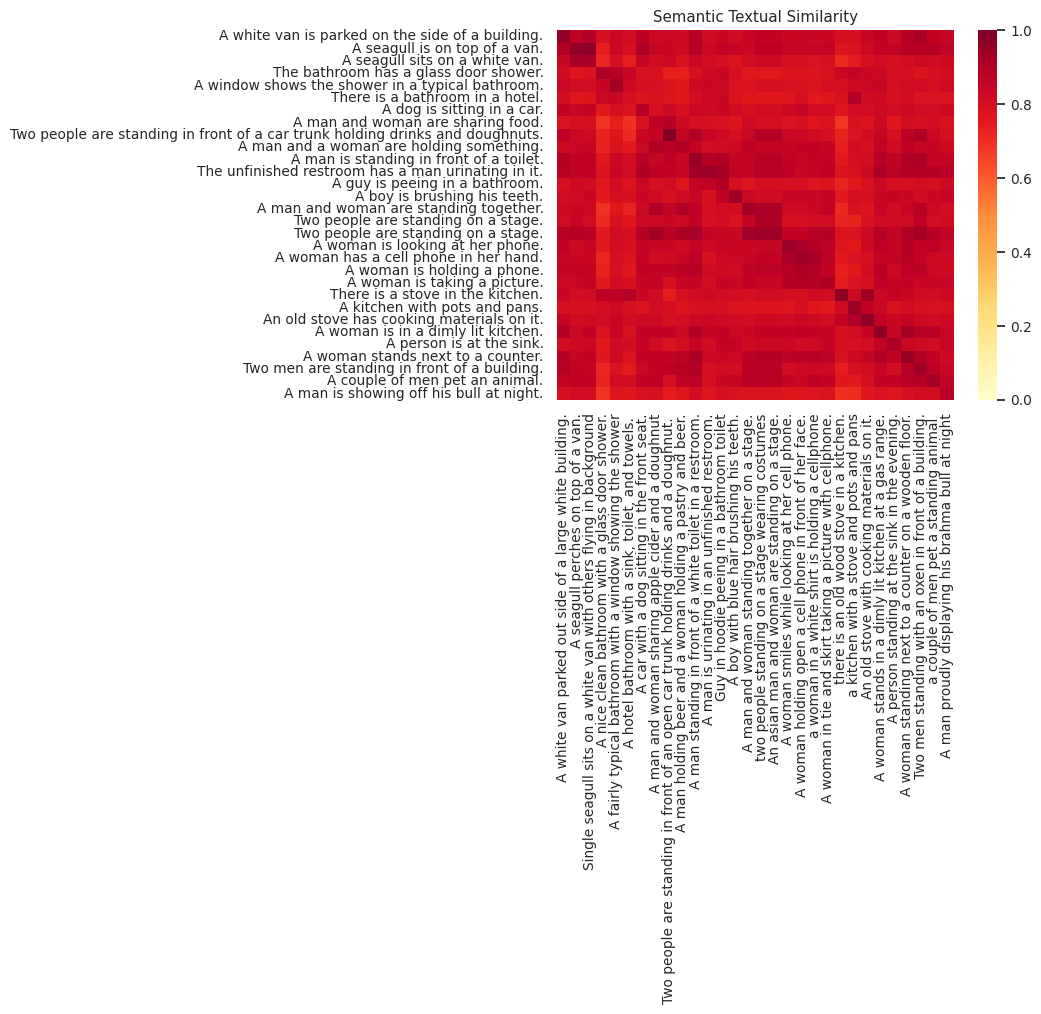

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_1_base_test, model_1_base_para)

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(test_examples[:30], paraphrased_test_examples, model_1_base_test, model_1_base_para, 90)

#### model_1_trained_coco

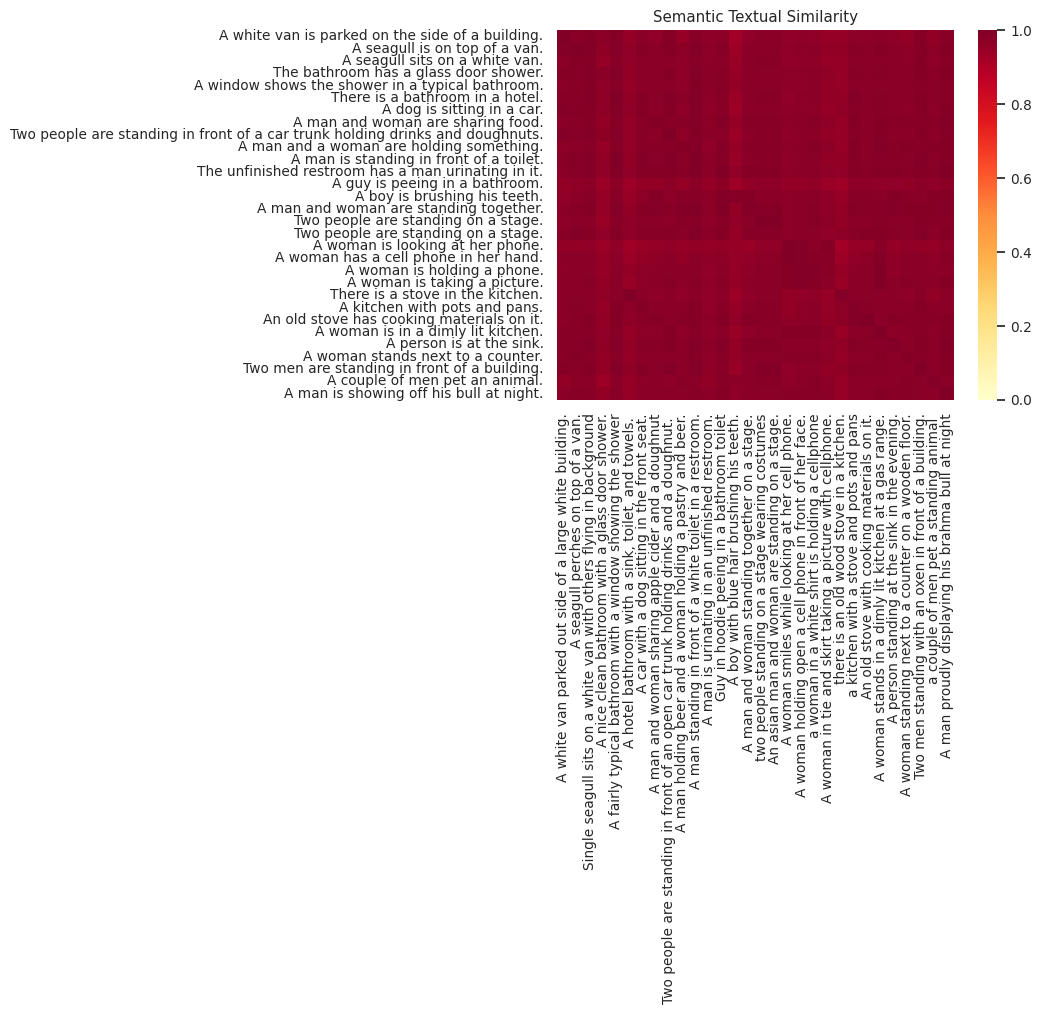

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_1_trained_coco_test, model_1_trained_coco_para)

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(test_examples[:30], paraphrased_test_examples, model_1_trained_coco_test, model_1_trained_coco_para, 90)

#### model_1_trained_sts

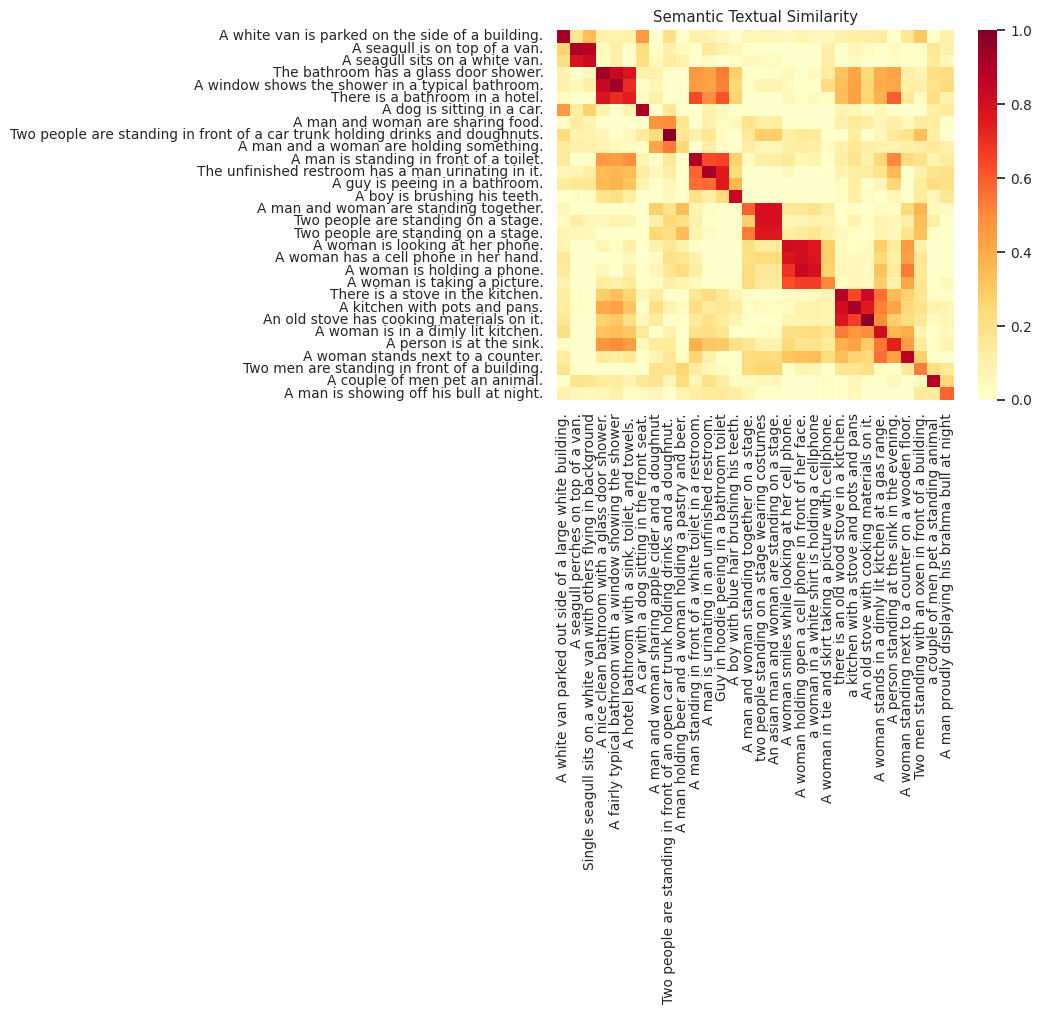

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_1_trained_sts_test, model_1_trained_sts_para)

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(test_examples[:30], paraphrased_test_examples, model_1_trained_sts_test, model_1_trained_sts_para, 90)

#### model_2_base

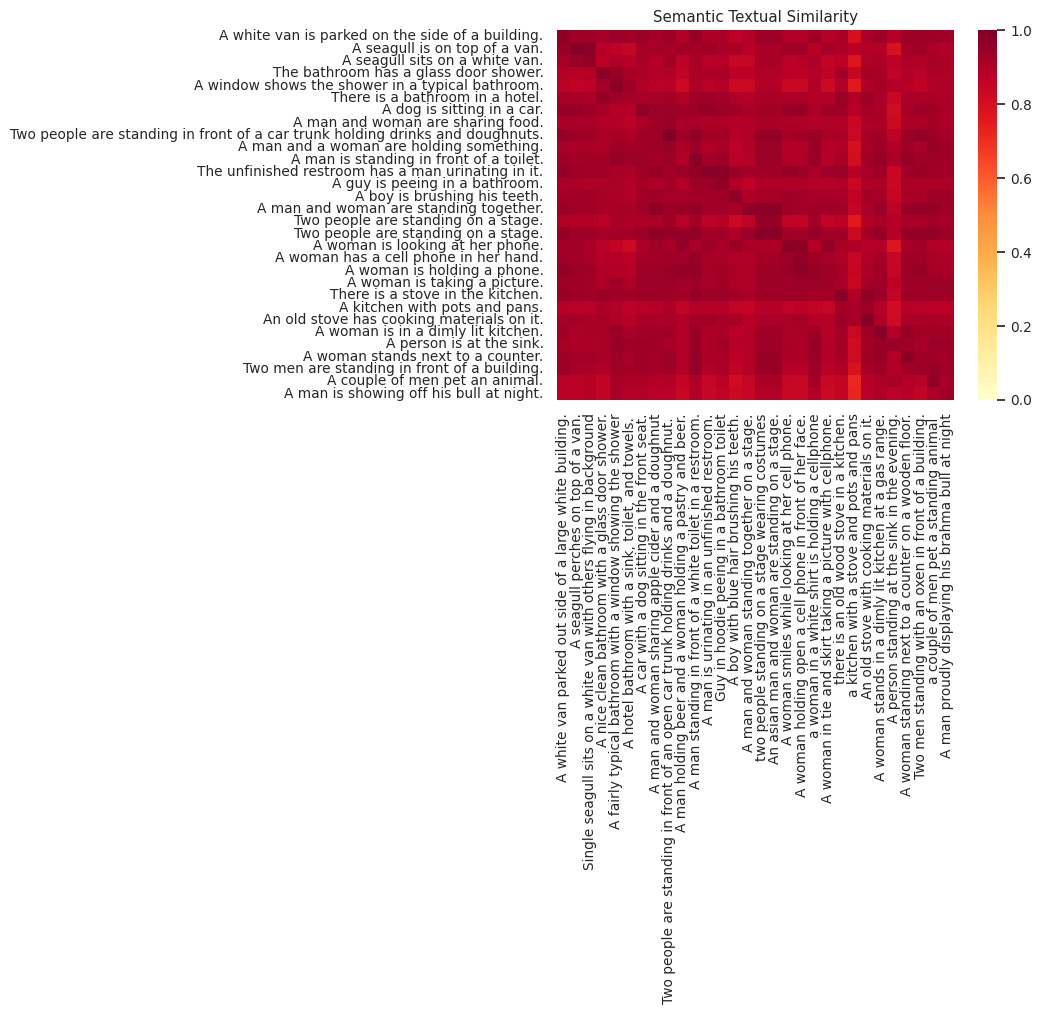

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_2_base_test, model_2_base_para)

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(test_examples[:30], paraphrased_test_examples, model_2_base_test, model_2_base_para, 90)

#### model_2_trained

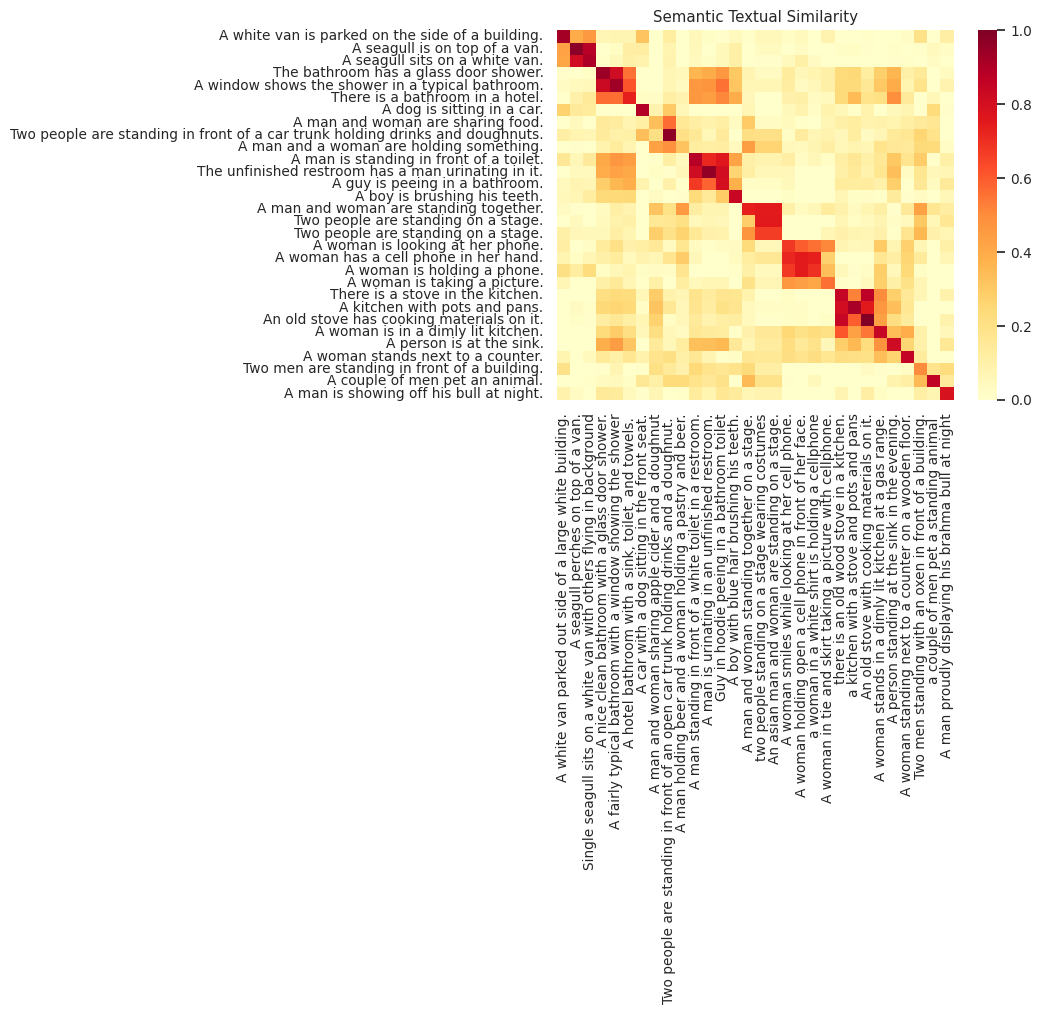

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_2_trained_test, model_2_trained_para)

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(test_examples[:30], paraphrased_test_examples, model_2_trained_test, model_2_trained_para, 90)

#### model_3_base

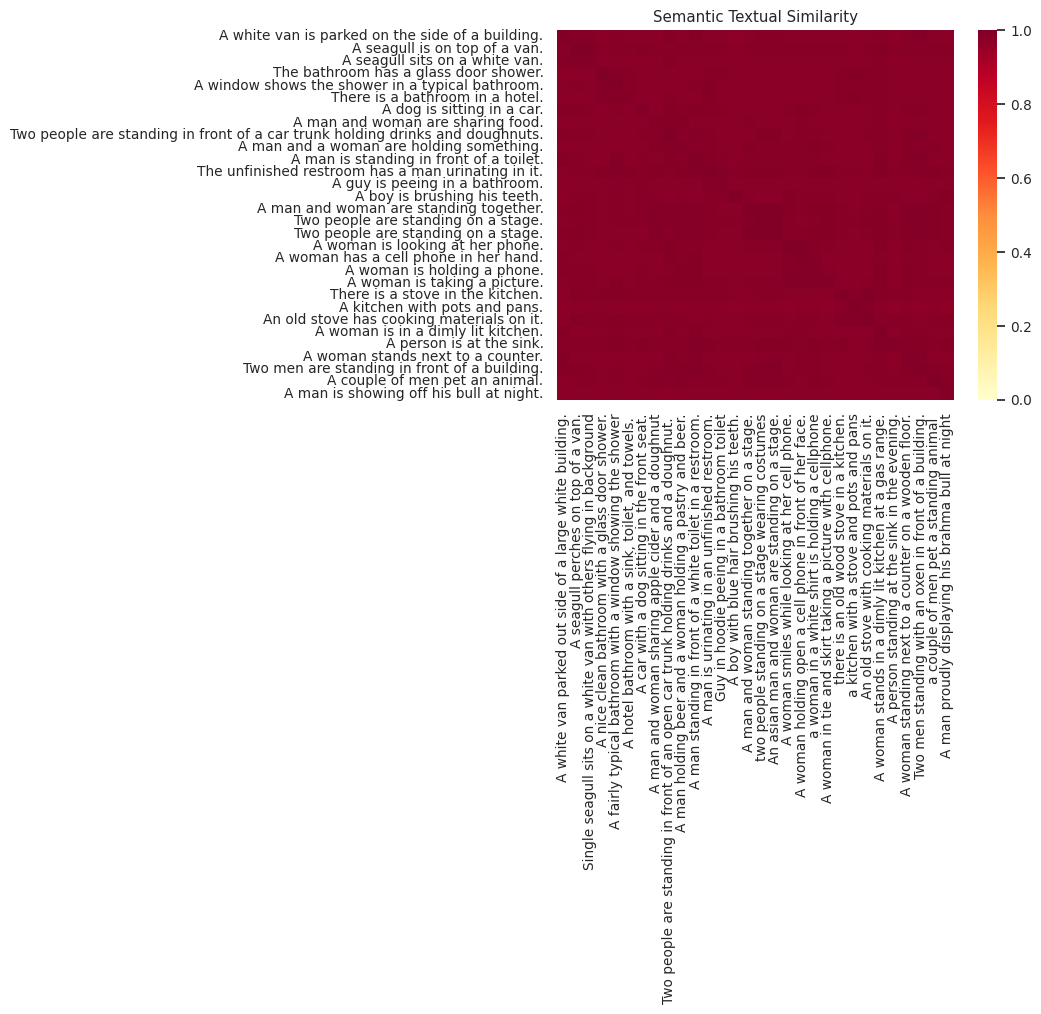

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_3_base_test, model_3_base_para)

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(test_examples[:30], paraphrased_test_examples, model_3_base_test, model_3_base_para, 90)

#### model_3_trained

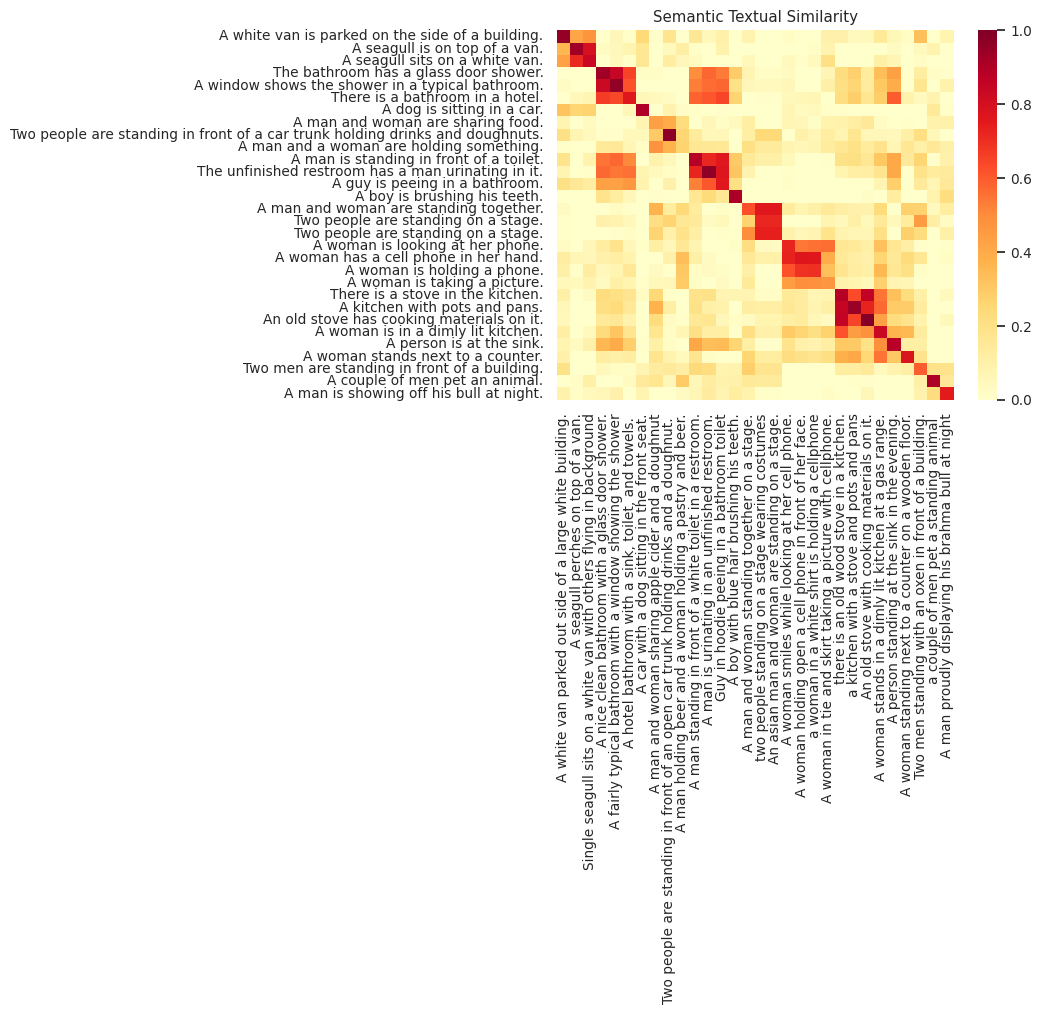

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_3_trained_test, model_3_trained_para)

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(test_examples[:30], paraphrased_test_examples, model_3_trained_test, model_3_trained_para, 90)

### GPT Test set

#### model_1_base

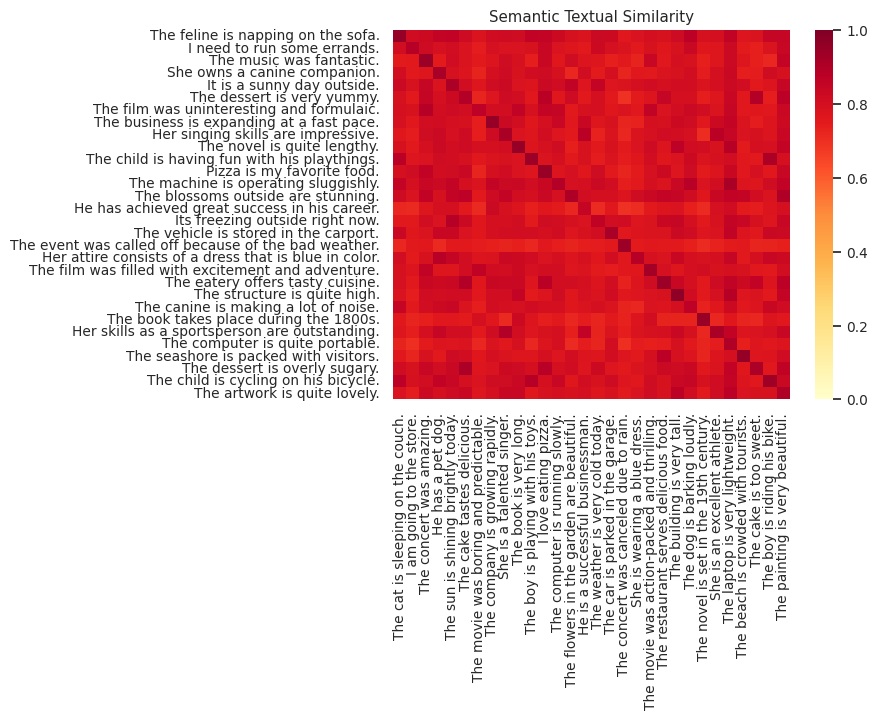

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_1_base_gpt1[:30], model_1_base_gpt2[:30])

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(GPT_set1[:30], GPT_set2[:30], model_1_base_gpt1[:30], model_1_base_gpt2[:30], 90)

#### model_1_trained_coco

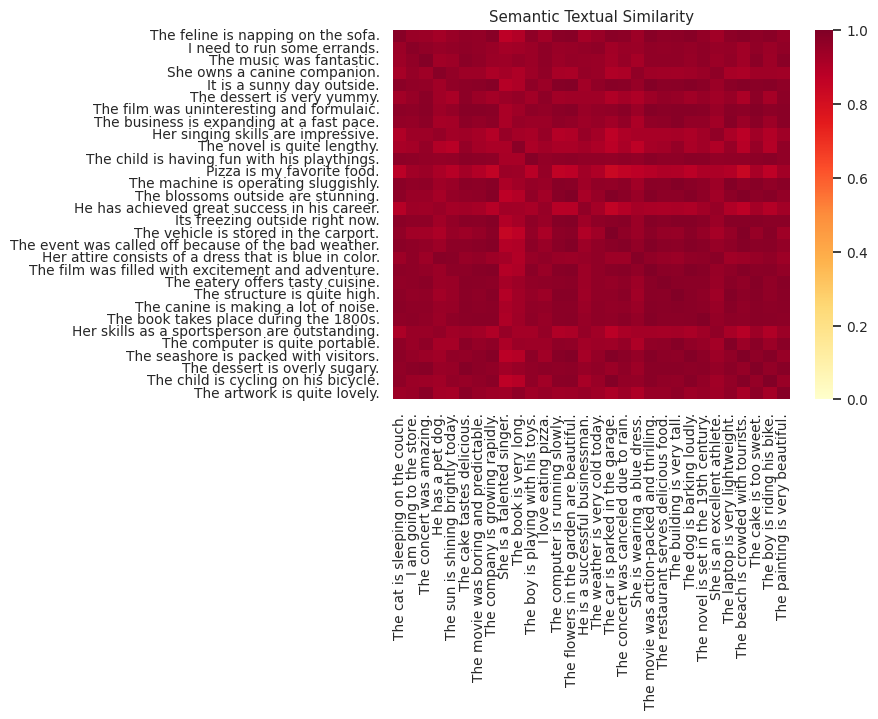

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_1_trained_coco_gpt1[:30], model_1_trained_coco_gpt2[:30])

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(GPT_set1[:30], GPT_set2[:30], model_1_trained_coco_gpt1[:30], model_1_trained_coco_gpt2[:30], 90)

#### model_1_trained_sts

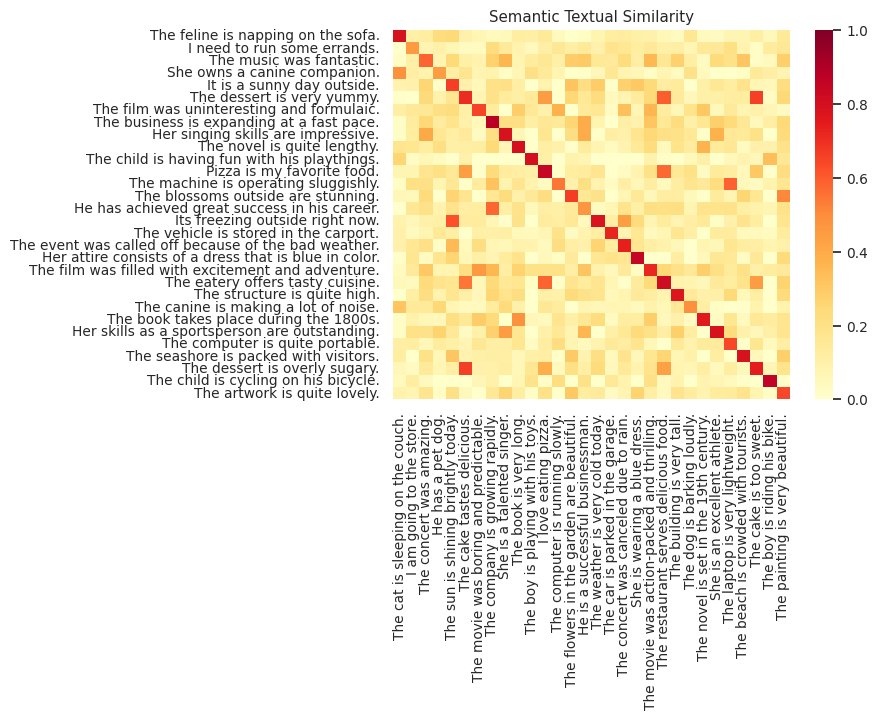

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_1_trained_sts_gpt1[:30], model_1_trained_sts_gpt2[:30])

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(GPT_set1[:30], GPT_set2[:30], model_1_trained_sts_gpt1[:30], model_1_trained_sts_gpt2[:30], 90)

#### model_2_base

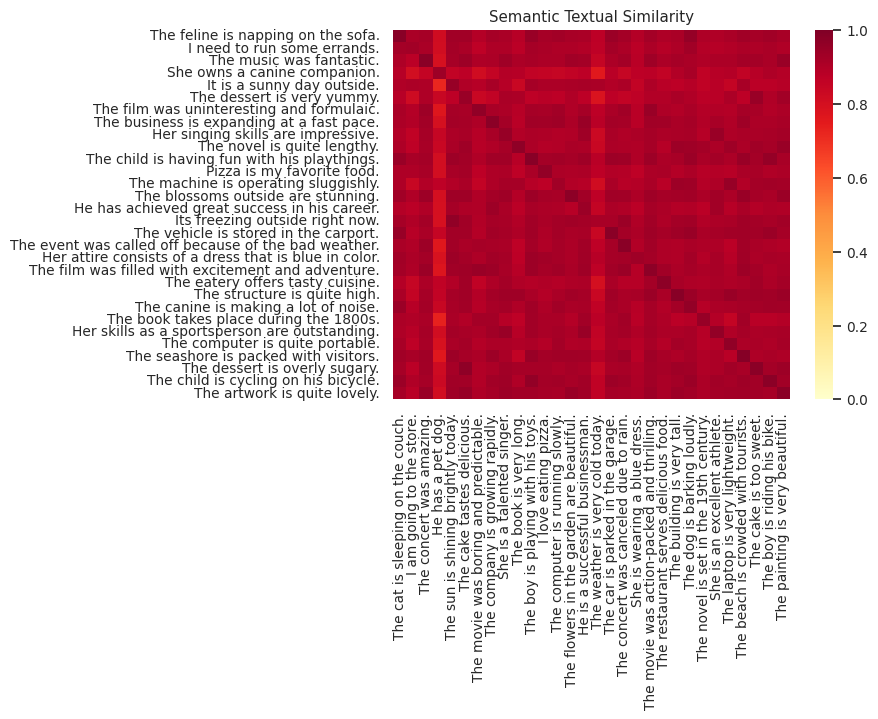

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_2_base_gpt1[:30], model_2_base_gpt2[:30])

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(GPT_set1[:30], GPT_set2[:30], model_2_base_gpt1[:30], model_2_base_gpt2[:30], 90)

#### model_2_trained

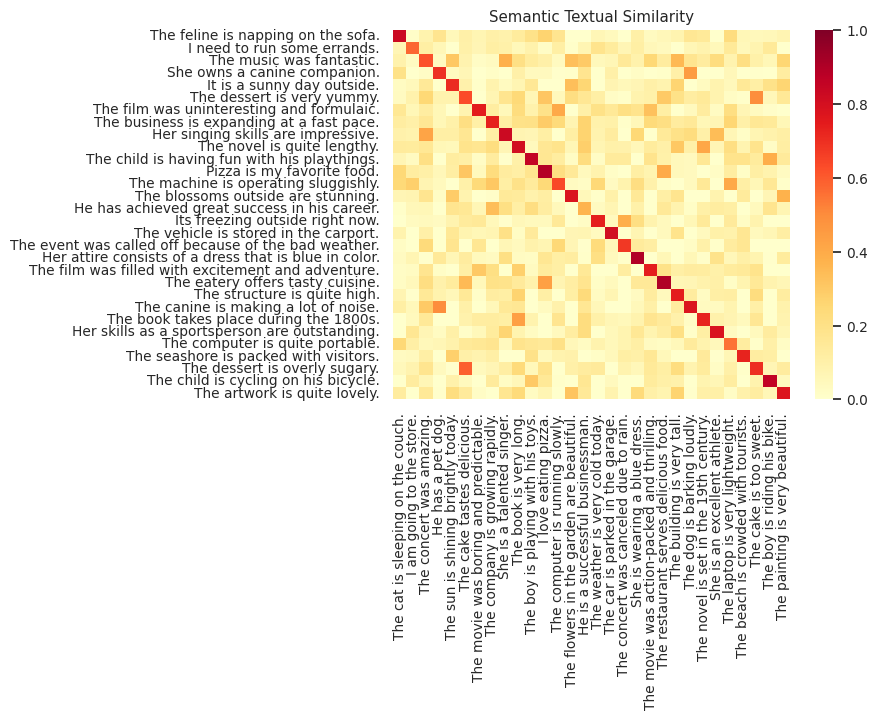

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_2_trained_gpt1[:30], model_2_trained_gpt2[:30])

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(GPT_set1[:30], GPT_set2[:30], model_2_trained_gpt1[:30], model_2_trained_gpt2[:30], 90)

#### model_3_base

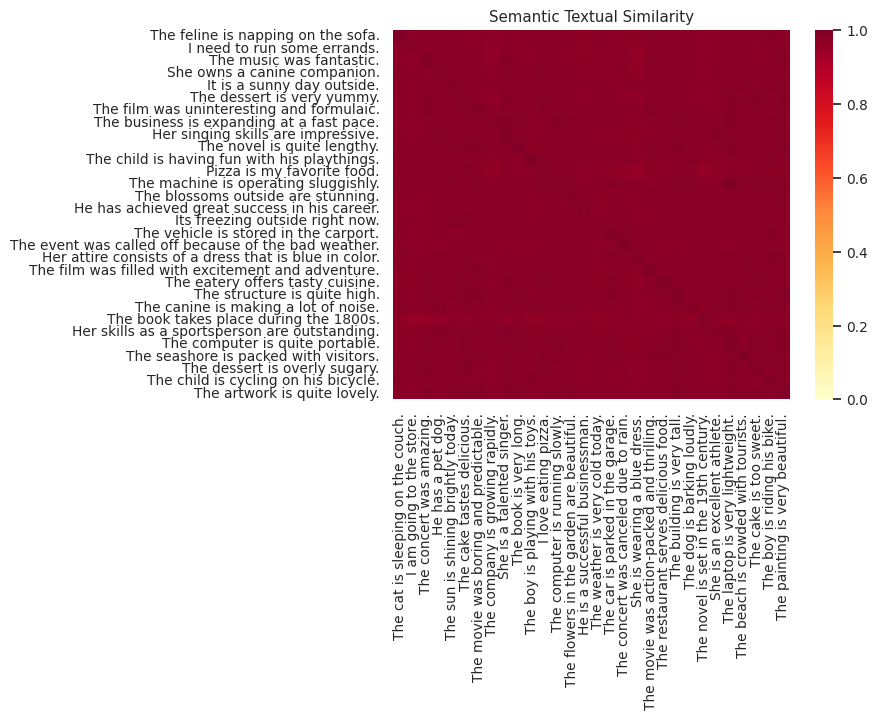

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_3_base_gpt1[:30], model_3_base_gpt2[:30])

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(GPT_set1[:30], GPT_set2[:30], model_3_base_gpt1[:30], model_3_base_gpt2[:30], 90)

#### model_3_trained

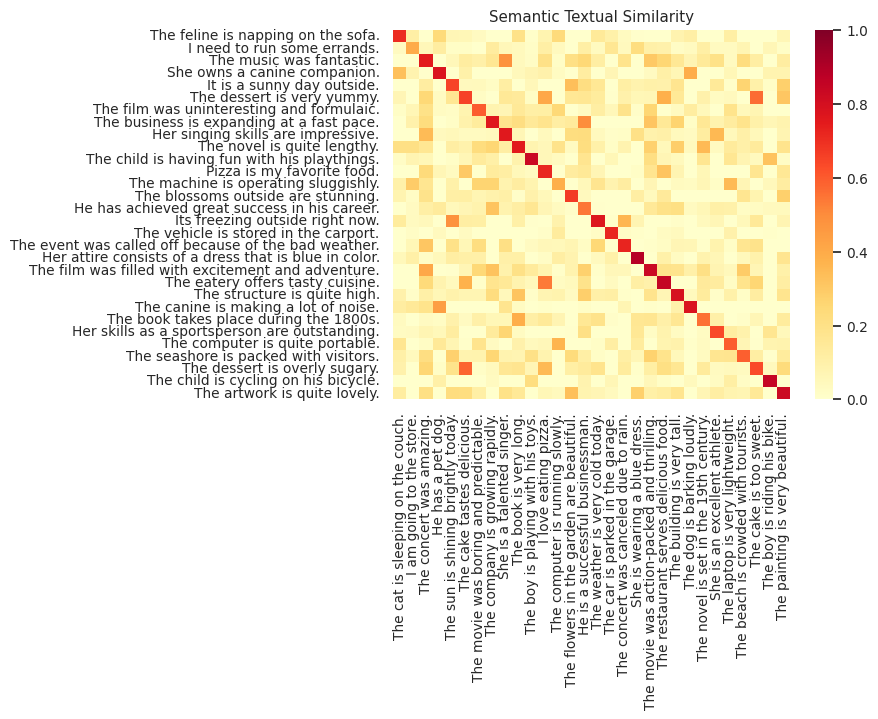

In [ ]:
from sentence_transformers import SentenceTransformer, util

#Compute cosine-similarities
cosine_scores = util.cos_sim(model_3_trained_gpt1[:30], model_3_trained_gpt2[:30])

# Plotting the similarity
def plot_similarity(labelsx,labelsy, features_test, features_para, rotation):
  cosine_scores = util.cos_sim(features_test, features_para)
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      cosine_scores,
      xticklabels=labelsx,
      yticklabels=labelsy,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labelsx, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

plot_similarity(GPT_set1[:30], GPT_set2[:30], model_3_trained_gpt1[:30], model_3_trained_gpt2[:30], 90)